### **Relevant Data**
- Over the waves, the participants mostly remain the same. According to the codebook, only a few new individuals are added in each wave.
- Based on the EDA, the data must be filtered using the following criteria:
  1. Include only **elderly individuals** (age 50 years or older).
  2. Include only **living individuals** (exclude those who passed away during the waves).
  3. Include only **in-person surveyed participants** (exclude observations based on reports from family members or relatives).
  4. Include only **Respondents** (specific details not visible in this section).

- **Additional Notes**:  
  - Filtering will only consider the last wave (wave 5) because of the significant time gap between waves, which are non-consecutive (approximately three years apart).  
  - **Reason for choosing wave 5**:  
    - Elderly health conditions tend to change annually. Considering this, using wave 5 provides the most recent and reliable data for analyzing meaningful health changes.  


### **Step-by-Step for Exploratory Data Analysis (EDA) and Feature Selection Using Filters**

---

### **1. Understand the Context and Requirements**
1. **Business Objective**: Predict the risk (probability) of hospitalization in older adults.
2. **Data Characteristics**:
   - Panel data: cross-sectional + time series data.
   - Irregular time intervals between waves.
   - Focus on the last wave (wave 5) for prediction due to its relevance and recency.
   - Target variable is highly imbalanced (1.4/8.6).

---

### **2. Exploratory Data Analysis (EDA)**

#### **A. Data Understanding and Delimitation**
1. **Identify the Observation Subjects**:
   - Initial subjects: Respondent (R), Spouse (S), Home (H).
   - Justification: Work only with `Respondent (R)` as their personal characteristics are directly relevant for prediction.
2. **Age Filtering**:
   - Filter older adults: retain only individuals aged 50 years or older.
3. **Available Variables**:
   - Approximately 469 variables after the initial delimitation.

#### **B. Missing Data Analysis**
1. Calculate the percentage of missing values for each column.
2. Visualize missing data:
   - Create a bar plot showing the percentage of missing values by column.
3. **Nature of Missing Data**:
   - Identified as MNAR (Missing Not At Random).
   - Strategy: Treat missing values (`NaN`) as an additional category and let the model determine their relevance.

#### **C. Data Imbalance Analysis**
1. Evaluate the imbalance in the target variable.
2. **Strategy for Imbalanced Data**:
   - Use oversampling techniques like **SMOTE** (Synthetic Minority Oversampling Technique) to balance the dataset.

#### **D. Analysis of Categorical and Numerical Variables**
1. Identify:
   - **Numerical Variables**: Example, hospitalization costs.
   - **Categorical Variables**: Represent 90% of the dataset (binary: 0/1).
2. Identify **cardinality** (unique values):
   - Remove variables with extremely high or low cardinality.

#### **E. Correlation Analysis**
1. Calculate correlation for categorical variables:
   - Use **Cramer’s V** to measure relationships between categorical variables.
2. Calculate correlations for numerical variables:
   - Use Pearson or Spearman correlation.

---

### **3. Feature Selection Using Filters**

#### **A. Filter-Based Feature Selection Methods**
1. **Remove Low Variability**:
   - Eliminate constant or near-constant variables (e.g., columns with variance close to 0).
   - Calculate the variance for each variable and filter based on a low threshold.
2. **Correlation Analysis**:
   - Use correlation to identify redundant variables.
   - Keep only one variable from highly correlated pairs (threshold > 0.8).
3. **Statistical Measures**:
   - Apply techniques such as **Chi-square** (for categorical variables) or **ANOVA** (for numerical variables) to evaluate the relationship between features and the target variable.
4. **Mutual Information**:
   - Calculate mutual information between each variable and the target to measure nonlinear dependencies.
5. **Univariate Selection**:
   - Select the best variables based on univariate statistical tests.

#### **B. Importance-Based Reduction**
1. Use a baseline model like Random Forest to compute feature importance.
2. Select the top 30 variables with the highest importance scores.

---

### **4. Proposed Workflow**

1. **EDA**:
   - Analyze missing data, imbalance, and general characteristics of the dataset.
2. **Initial Filtering**:
   - Filter by age (>50 years), remove low-variance variables, and focus only on Respondents (R).
3. **Preprocessing**:
   - Balance the dataset using SMOTE.
   - Impute or categorize missing values.
4. **Feature Selection**:
   - Apply filter methods (variance, correlation, ANOVA, Chi-square, mutual information).
   - Reduce to the top 30 best features.
5. **Baseline Model**:
   - Train a baseline model with the selected features to evaluate performance.
6. **Fine-Tuning**:
   - Adjust hyperparameters and optimize the final model.



In [ ]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

#"content/drive/MyDrive/shared-with-me/anyoneAI_FP"

if IN_COLAB:
    ROOT_DIR = "/content/drive/MyDrive/anyoneAI_FP/"
    %cd $ROOT_DIR


Mounted at /content/drive
/content/drive/MyDrive/anyoneAI_FP


In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency



def handle_missing_values(df, numeric_placeholder=-999, categorical_placeholder='Missing'):
    """
    Replace missing values in numerical and categorical columns.
    Args:
        df (pd.DataFrame): The input dataset.
        numeric_placeholder: Placeholder for missing numerical values.
        categorical_placeholder: Placeholder for missing categorical values.
    Returns:
        pd.DataFrame: The dataframe with missing values handled.
    """
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(numeric_placeholder)
        else:  # Categorical columns
            df[col] = df[col].fillna(categorical_placeholder)
    return df


def balance_data(X, y):
    """
    Balance the dataset using SMOTE.
    Args:
        X (pd.DataFrame): Features dataframe.
        y (pd.Series): Target variable.
    Returns:
        tuple: Balanced features (X) and target (y).
    """
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced


def filter_by_age(df, age_column='r5agey', age_threshold=50):
    """
    Filter rows by age threshold.
    Args:
        df (pd.DataFrame): The input dataset.
        age_column (str): The column containing age data.
        age_threshold (int): The minimum age to include.
    Returns:
        pd.DataFrame: Filtered dataset.
    """
    return df[df[age_column] >= age_threshold]



def remove_low_variability(df, threshold=0.01):
    """
    Remove features with low variance after ensuring all columns are numeric.
    Args:
        df (pd.DataFrame): Input dataframe.
        threshold (float): Variance threshold.
    Returns:
        pd.DataFrame: Dataframe with low-variance features removed.
    """
    # Ensure all columns are numeric
    df_numeric = df.select_dtypes(include=['number'])

    # Apply VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)
    df_filtered = selector.fit_transform(df_numeric)

    # Return filtered DataFrame with selected columns
    return pd.DataFrame(df_filtered, columns=df_numeric.columns[selector.get_support()])


def handle_categorical_cardinality(df, max_cardinality=100, min_cardinality=2):
    """
    Remove categorical features with very high or very low cardinality.
    Args:
        df (pd.DataFrame): Input dataframe.
        max_cardinality (int): Maximum allowed unique values.
        min_cardinality (int): Minimum allowed unique values.
    Returns:
        pd.DataFrame: Dataframe with filtered categorical variables.
    """
    for col in df.select_dtypes(include=['object']).columns:
        unique_values = df[col].nunique()
        if unique_values > max_cardinality or unique_values < min_cardinality:
            df = df.drop(columns=[col])
    return df


def calculate_v_cramer(df, categorical_columns):
    """
    Calculate V Cramer correlation for categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    Returns:
        pd.DataFrame: Correlation matrix for categorical variables.
    """
    def v_cramer(confusion_matrix):
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        return np.sqrt(phi2 / min(k - 1, r - 1))

    corr_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
            else:
                confusion_matrix = pd.crosstab(df[col1], df[col2])
                corr_matrix.loc[col1, col2] = v_cramer(confusion_matrix)
    return corr_matrix


def filter_alive_respondents(df, status_column='r5iwstat', alive_value='1.Resp, alive'):
    """
    Filter the dataset to include only alive respondents based on the R5IWSTAT variable.

    Args:
        df (pd.DataFrame): Input dataset.
        status_column (str): Column name indicating respondent's status (default is 'R5IWSTAT').
        alive_value (int): Value in the status column that represents 'alive' (default is 1).

    Returns:
        pd.DataFrame: Filtered dataset containing only alive respondents.
    """
    # Filter rows where the status column equals the alive value
    filtered_df = df[df[status_column] == alive_value]
    return filtered_df



def analyze_and_handle_missing_values(df, threshold=30):
    """
    Analyze missing values, visualize them, and drop columns exceeding the threshold.

    Args:
        df (pd.DataFrame): Input dataframe.
        threshold (int): Percentage threshold for dropping columns (default: 30).

    Returns:
        pd.DataFrame: Dataframe after dropping columns with excessive missing values.
    """
    # Calculate the percentage of missing values
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Visualize missing data
    plt.figure(figsize=(10, 6))
    missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title("Percentage of Missing Values by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=12)
    plt.ylabel("Percentage of Missing Values", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

    # Drop columns exceeding the threshold
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    print(f"Columns dropped (>{threshold}% missing): {list(columns_to_drop)}")

    df = df.drop(columns=columns_to_drop)
    return df


import matplotlib.pyplot as plt

def remove_columns_with_missing_values(df, missing_values_threshold=30, visualize=True):
    """
    Analyze missing values, optionally visualize them, and drop columns exceeding the threshold.

    Args:
        df (pd.DataFrame): Input dataframe.
        missing_values_threshold (int): Percentage threshold for dropping columns (default: 30).
        visualize (bool): Whether to visualize the missing data (default: True).

    Returns:
        pd.DataFrame: Dataframe after dropping columns with excessive missing values.
    """
    # Calculate the percentage of missing values
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    if visualize:
        # Visualize missing data with highlighting for columns exceeding the threshold
        plt.figure(figsize=(10, 6))
        colors = ['red' if val > missing_values_threshold else 'skyblue' for val in missing_percentage]
        missing_percentage.sort_values(ascending=False).plot(kind='bar', color=colors)
        plt.axhline(y=missing_values_threshold, color='gray', linestyle='--', linewidth=1.5, label=f'Threshold ({missing_values_threshold}%)')
        plt.title("Percentage of Missing Values by Column", fontsize=16)
        plt.xlabel("Columns", fontsize=12)
        plt.ylabel("Percentage of Missing Values", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.show()

    # Identify and drop columns exceeding the threshold
    columns_to_drop = missing_percentage[missing_percentage > missing_values_threshold].index
    print(f"Dropping {len(columns_to_drop)} columns (>{missing_values_threshold}% missing): {list(columns_to_drop)}")

    # Drop the columns
    filtered_df = df.drop(columns=columns_to_drop)

    # Print updated shape
    print(f"Updated dataframe shape: {filtered_df.shape}")

    return filtered_df



def cramers_v(x, y):
    """
    Calculate Cramér's V statistic for categorical association.
    Args:
        x (pd.Series): First categorical variable.
        y (pd.Series): Second categorical variable.
    Returns:
        float: Cramér's V statistic.
    """
    # Ensure inputs are strings
    x, y = x.astype(str), y.astype(str)

    contingency_table = pd.crosstab(x, y)
    if contingency_table.size == 0:  # Handle empty tables
        return np.nan

    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape

    # Handle cases where min(k-1, r-1) is 0
    if min(k - 1, r - 1) == 0:
        return np.nan

    return np.sqrt(phi2 / min(k - 1, r - 1))


def cramers_v_matrix(df):
    """
    Create a Cramér's V correlation matrix for all categorical variables.
    Args:
        df (pd.DataFrame): Dataframe containing categorical variables.
    Returns:
        pd.DataFrame: Cramér's V correlation matrix.
    """
    # Automatically filter categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Ensure all categorical columns are strings
    df = df[categorical_columns].astype(str)

    cramers_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                cramers_matrix.loc[col1, col2] = 1.0
            else:
                cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    return cramers_matrix.astype(float)


def remove_redundant_features_cramers(df, cramers_matrix, threshold=0.8, target_column='r5hosp1y'):
    """
    Use a precomputed Cramér's V matrix to identify and remove redundant categorical features,
    ensuring the target variable is not removed.

    Args:
        df (pd.DataFrame): Dataframe containing categorical variables.
        cramers_matrix (pd.DataFrame): Precomputed Cramér's V correlation matrix.
        threshold (float): Threshold for Cramér's V to consider redundancy.
        target_column (str): The target variable that must not be removed.

    Returns:
        pd.DataFrame: Dataframe with redundant features removed.
    """
    # Identify redundant variables
    redundant_vars = set()
    for col1 in cramers_matrix.columns:
        for col2 in cramers_matrix.columns:
            if col1 != col2 and cramers_matrix.loc[col1, col2] > threshold:
                # Ensure the target variable is not added to redundant features
                if col2 != target_column:
                    redundant_vars.add(col2)

    # Drop redundant variables while preserving the target variable
    reduced_df = df.drop(columns=redundant_vars, errors='ignore')
    print(f"Removed {len(redundant_vars)} redundant features: {redundant_vars}")
    return reduced_df




def handle_all_missing_as_category(df, target_column='r5hosp1y', missing_label='Missing', numerical_fill_value=-1):
    """
    Treat missing values (NaN) in all columns as an additional category for categorical columns
    and assign a default value (-1) for numerical columns, excluding the target column.

    Args:
        df (pd.DataFrame): The input dataset.
        target_column (str): The column to exclude from missing value handling.
        missing_label (str): The label to replace missing values with in categorical columns (default: 'Missing').
        numerical_fill_value (int or float): The value to replace missing values with in numerical columns (default: -1).

    Returns:
        pd.DataFrame: The dataset with missing values handled appropriately.
    """
    df = df.copy()

    for col in df.columns:
        if col == target_column:
            # Skip the target column
            continue
        if df[col].dtype.name == 'category' or df[col].dtype == object:
            # Handle categorical columns
            if df[col].dtype.name == 'category':
                # Add the missing label to the categories if the column is categorical
                df[col] = df[col].cat.add_categories([missing_label])
            # Replace missing values with the missing label
            df[col] = df[col].fillna(missing_label)
        elif pd.api.types.is_numeric_dtype(df[col]):
            # Handle numerical columns
            df[col] = df[col].fillna(numerical_fill_value)

    return df



def extract_wave_data(df, wave_number):
    """
    Extract variables from a specific wave based on the second character of their names.
    Section 1.4 of the harmonized MHAS documentation (version C.2) explains that the second character
    of any variable refers to the particular wave the variable is encoding.

    Parameters:
    - df: DataFrame
    - wave_number: int or str, wave identifier (1, 2, 3, 4, 5; the character 'a' denotes a cross-wave variable)

    Returns:
    - DataFrame with columns for the specified wave.
    """
    # Select variables from a specific wave
    specific_wave_columns = [col for col in df.columns if len(
        col) > 1 and col[1] == str(wave_number)]

    # Select cross-wave variables
    cross_wave = [col for col in df.columns if len(col) > 1 and col[1] == 'a']

    # Combine specific and common variables
    wave_columns = list(set(specific_wave_columns + cross_wave))

    return df[wave_columns]


def extract_respondent_data(df):
    """
    Extract variables from respondent.
    Section 1.4 of the harmonized MHAS documentation (version C.2) explains that the first character
    of any variable refers to the particular individual referred to by the variable.

    Parameters:
    - df: DataFrame

    Returns:
    - DataFrame with columns for respondent.
    """
    return df[[col for col in df.columns if col.startswith('r')]]


def remove_missing_values(df, column_name):
    """
    Remove all rows matching missing values from a specified column

    Parameters:
    - df: DataFrame
    - column_name: name of column to search for missing values

    Returns:
    - DataFrame with no missing values for the specified column.
    """

    df = df[df[column_name].notna()]

    return df


def missing_value_ratio(df, ratio):
    """
    Identify variables with the specified missing value ratio

    Parameters:
    - df: DataFrame
    - ratio: proportion of missing values

    Returns:
    - List of columns with a ratio equal to or higher than the one specified by the user.
    """

    # Identify categorical columns
    # categorical_columns = df.select_dtypes(
    # include=['object', 'category']).columns

    # Identify and store columns with the specified missing value ratio
    columns_matching_missing_value_ratio = [
        col for col in df.columns
        if df[col].isnull().mean() > ratio
    ]

    print(f"Variables with a missing value ratio higher than {ratio}: {columns_matching_missing_value_ratio}")
    print(f"Count of variables with a missing ratio higher than {ratio}: {len(columns_matching_missing_value_ratio)}")

    return columns_matching_missing_value_ratio




def save_categorical_features_with_values(df: pd.DataFrame, file_name: str):
    """
    Saves the unique values of categorical features in a DataFrame to a text file.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        file_name (str): The name of the text file to save the output.
    """
    try:
        # Select only categorical columns
        categorical_cols = df.select_dtypes(include=['object']).columns
        file_path = os.path.join(DATASET_ROOT_PATH, file_name)
        # Open the file for writing
        with open(file_path, 'w') as f:
            for column in df.columns:
                # Get the unique values of the column
                unique_values = df[column].unique()
                # Limit the number of values shown for readability
                unique_values_preview = unique_values[:10]  # Show up to 10 values
                # Write the feature name and unique values to the file
                f.write(f"{column}: {list(unique_values_preview)}\n\n")

        print(f"Categorical features with their unique values have been saved to '{file_name}'")
    except Exception as e:
        print(f"An error occurred: {e}")




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values(df):
    """
    Plot the percentage of missing values for each column in the dataset.
    Args:
        df (pd.DataFrame): Input dataframe.
    """
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette="viridis")
    plt.title("Percentage of Missing Values by Column", fontsize=16)
    plt.xlabel("Percentage of Missing Values", fontsize=12)
    plt.ylabel("Columns", fontsize=12)
    plt.show()

def plot_class_distribution(target):
    """
    Plot the distribution of the target variable to visualize class imbalance.
    Args:
        target (pd.Series): Target variable.
    """
    class_counts = target.value_counts()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")
    plt.title("Class Distribution of Target Variable", fontsize=16)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

    print(f"Class Distribution:\n{class_counts}")
    print(f"Class Ratios:\n{class_counts / class_counts.sum() * 100}")


def plot_numerical_distributions(df, numeric_columns):
    """
    Plot the distributions of numerical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        numeric_columns (list): List of numerical column names.
    """
    for col in numeric_columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df[col].dropna(), kde=True, bins=30, color="skyblue")
        plt.title(f"Distribution of {col}", fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.show()


def plot_categorical_distributions(df, categorical_columns):
    """
    Plot the distributions of categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    """
    for col in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=df[col], order=df[col].value_counts().index, palette="muted")
        plt.title(f"Distribution of {col}", fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45)
        plt.show()


def plot_correlation_matrix(df, numeric_columns):
    """
    Plot a heatmap of correlations between numerical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        numeric_columns (list): List of numerical column names.
    """
    corr_matrix = df[numeric_columns].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Matrix", fontsize=16)
    plt.show()


def plot_v_cramer_matrix(df, categorical_columns):
    """
    Plot a heatmap of V Cramer correlations between categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    """
    corr_matrix = calculate_v_cramer(df, categorical_columns)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("V Cramer Correlation Matrix", fontsize=16)
    plt.show()


def plot_categorical_cardinality(df, categorical_columns):
    """
    Plot the cardinality (number of unique values) of categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    """
    cardinality = {col: df[col].nunique() for col in categorical_columns}
    cardinality = pd.Series(cardinality).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=cardinality.values, y=cardinality.index, palette="cool")
    plt.title("Cardinality of Categorical Variables", fontsize=16)
    plt.xlabel("Number of Unique Values", fontsize=12)
    plt.ylabel("Variables", fontsize=12)
    plt.show()





In [ ]:
# Load the dataset
file_path = 'H_MHAS_c2.dta'
print("Loading the dataset...")
raw_df = pd.read_stata(file_path)
raw_df.to_csv("raw_df.csv", index=False)

Loading the dataset...
Dataset loaded successfully with shape: (26839, 5241)
Preview of the dataset:


,codent01,codent03,ps3,ent2,np,unhhidnp,rahhidnp,tipent_01,tipent_03,tipent_12,...,s4satlife_m,s5satlife_m,r3satlifez,r4satlifez,r5satlifez,s3satlifez,s4satlifez,s5satlifez,r2cantril,s2cantril
0,1.Selected person,1.Selected person in 2001,1.0,1.0,10,110.0,110,"12.Direct, second interview","12.Direct, second interview","1.Direct, follow-up interview",...,NaN,NaN,1.510731,NaN,NaN,1.510731,NaN,NaN,1.0,NaN
1,2.Spouse of selected person,2.Spouse of selected person in 2001,2.0,2.0,20,120.0,120,"11.Direct, first interview","11.Direct, first interview","1.Direct, follow-up interview",...,NaN,NaN,1.510731,-0.387025,-0.393398,1.510731,NaN,NaN,NaN,1.0
2,1.Selected person,1.Selected person in 2001,1.0,1.0,10,210.0,210,"11.Direct, first interview","22.Proxy, second interview","1.Direct, follow-up interview",...,NaN,NaN,-0.397267,-0.387025,-0.393398,NaN,NaN,NaN,NaN,5.0
3,2.Spouse of selected person,2.Spouse of selected person in 2001,2.0,2.0,20,220.0,220,"12.Direct, second interview","11.Direct, first interview","3.Proxy, follow-up interview",...,1.Agree,NaN,NaN,NaN,NaN,-0.397267,-0.387025,NaN,5.0,NaN
4,1.Selected person,1.Selected person in 2001,1.0,1.0,10,310.0,310,"11.Direct, first interview","11.Direct, first interview","1.Direct, follow-up interview",...,1.Agree,1.Agree,-0.397267,-0.387025,-0.393398,-0.397267,-0.387025,-0.393398,1.0,NaN



Filtering data for Wave 5...
Wave 5 dataframe shape: (26839, 1004)

Filtering data for direct respondents only...
Wave 5 respondent-only dataframe shape: (26839, 469)

Filtering data for elderly individuals (aged 50+)...
Wave 5 elderly individuals dataframe shape: (15868, 469)

Excluding individuals who passed away during the waves...
Wave 5 alive individuals dataframe shape: (15868, 469)

Visualizing missing values...


<ipython-input-3-50447ff25624>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette="viridis")


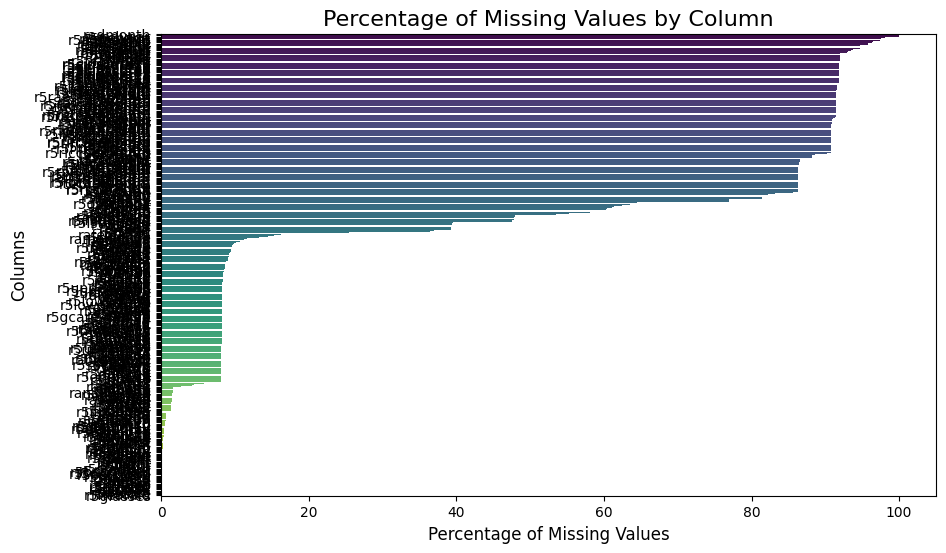


Removing columns with more than 30% missing values...


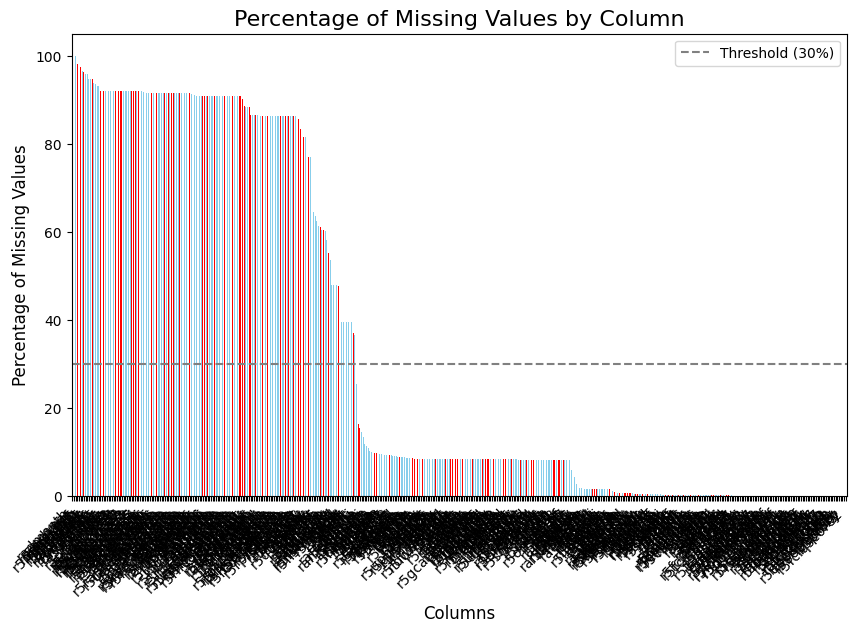

Dropping 172 columns (>30% missing): ['r5rircaredpm', 'r5rscarehrm', 'r5ripfcaren', 'r5racaany', 'r5alone', 'r5rircare', 'r5paina', 'r5ciqscore4', 'r5ciqscore14', 'r5bedhlp', 'r5pubage', 'r5rrcaredpm', 'r5hrtatlmt', 'r5rafcaredpmm', 'r5ciqscore10', 'r5ciqscore13', 'r5rircarehrm', 'r5rccarehr', 'r5hystere', 'r5rarcarehr', 'r5rifcare', 'r5rascarehr', 'r5ciqscore3', 'r5bed', 'r5ciqscore8', 'r5rrcarehrm', 'r5rfcaredpmm', 'r5rapfcaredpmm', 'r5rfcaren', 'r5rircaredpmm', 'r5ciqscore16', 'r5lifein_m', 'r5rscaredpmm', 'r5rccaredpmm', 'r5flstmnspd', 'r5rifcarehr', 'r5ciqscore5', 'r5rascare', 'radmonth', 'r5ciqscore11', 'r5rccarehrm', 'r5rscarehr', 'r5rccare', 'r5quitsmok', 'r5raccare', 'r5riscaredpmm', 'r5rorgnz', 'r5rpfcaredpm', 'r5rifcaren', 'r5haluc', 'r5riccaredpm', 'r5bathehlp', 'r5rascarehrm', 'r5rafcaredpm', 'r5rapfcarehr', 'r5riscare', 'r5breast', 'r5rifaany', 'r5rrcaredpmm', 'r5eathlp', 'r5medhlp', 'radyear', 'r5rfcarehr', 'r5rscaredpm', 'r5riccarehrm', 'r5riscarehr', 'r5ripfcarehr', 'r

In [ ]:
# Load the dataset
file_path = 'H_MHAS_c2.dta'
print("Loading the dataset...")
raw_df = pd.read_stata(file_path)
print(f"Dataset loaded successfully with shape: {raw_df.shape}")
print("Preview of the dataset:")
display(raw_df.head())  # Use display() for better rendering in Jupyter Notebook

# Step 1: Filter data from Wave 5
print("\nFiltering data for Wave 5...")
wave_5_df = extract_wave_data(raw_df, "5")
print(f"Wave 5 dataframe shape: {wave_5_df.shape}")

# Step 2: Include only direct respondents
print("\nFiltering data for direct respondents only...")
wave_5_respondents_df = extract_respondent_data(wave_5_df)
print(f"Wave 5 respondent-only dataframe shape: {wave_5_respondents_df.shape}")

# Step 3: Filter for elderly individuals aged 50 or older
print("\nFiltering data for elderly individuals (aged 50+)...")
elderly_individuals_df = filter_by_age(wave_5_respondents_df)
print(f"Wave 5 elderly individuals dataframe shape: {elderly_individuals_df.shape}")

# Step 4: Exclude individuals who passed away
print("\nExcluding individuals who passed away during the waves...")
alive_individual_df = filter_alive_respondents(elderly_individuals_df)
print(f"Wave 5 alive individuals dataframe shape: {alive_individual_df.shape}")

# Step 5: Visualize missing values
print("\nVisualizing missing values...")
plot_missing_values(alive_individual_df)

# Step 6: Remove columns with more than 30% missing values
missing_percentage_threshold = 30
print(f"\nRemoving columns with more than {missing_percentage_threshold}% missing values...")
df_filtered_by_missing_values = remove_columns_with_missing_values(alive_individual_df, missing_percentage_threshold)
print(f"Dataframe shape after removing columns with excessive missing values: {df_filtered_by_missing_values.shape}")

# Step 7: Handle the target column (r5hosp1y)
target_column = 'r5hosp1y'
target_mapping = {'1.Yes': 1, '0.No': 0}
print(f"\nProcessing the target column '{target_column}'...")
cleaned_df = (
    df_filtered_by_missing_values
    .dropna(subset=[target_column])  # Remove rows with missing target values
    .assign(**{target_column: df_filtered_by_missing_values[target_column].map(target_mapping)})  # Map to 1s and 0s
)
print(f"Dataframe shape after processing target column: {cleaned_df.shape}")

# Step 8: Handle missing values for all columns (excluding the target column)
print("\nHandling missing values for all columns...")
final_data = handle_all_missing_as_category(cleaned_df, target_column=target_column)
print(f"Final dataset shape: {final_data.shape}")

# Drop highly correlated variables with target variable
# Hospital nights, previous 12 months, r5hspnit1y,
#Number of doctor visits, previous 12 months, r5doctim1y

# columns_to_drop = ['r5hspnit1y', 'r5doctim1y']
# final_data = final_data.drop(columns=columns_to_drop, errors='ignore')

# Step 9: Save the cleaned dataset
output_path = 'cleaned_dataset_2.csv'
final_data.to_csv(output_path, index=False)
print(f"\nCleaned dataset saved successfully to {output_path}")


<ipython-input-28-50447ff25624>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")


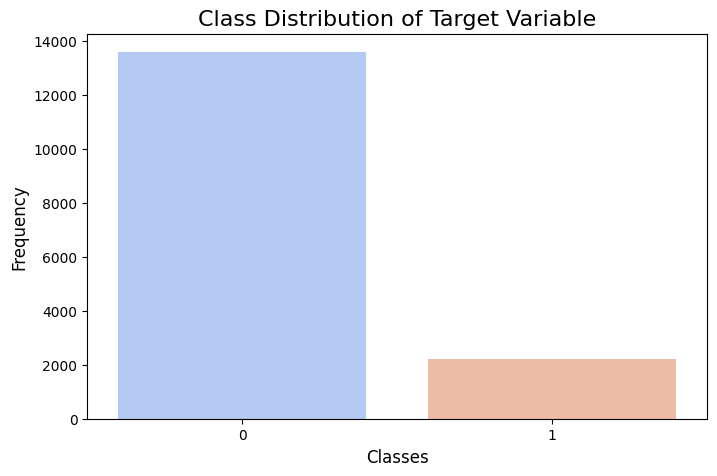

Class Distribution:
r5hosp1y
0    13595
1     2212
Name: count, dtype: int64
Class Ratios:
r5hosp1y
0    86.0062
1    13.9938
Name: count, dtype: float64


In [ ]:
data = final_data.copy()

plot_class_distribution(data ['r5hosp1y'])

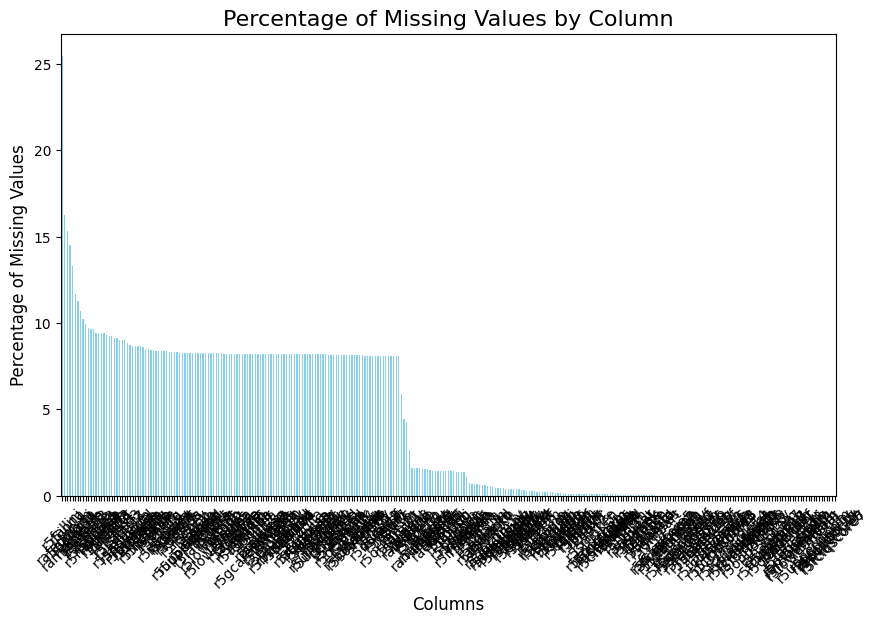

Columns dropped (>30% missing): []


,r5igxfr,r5oopdocf1y,r5pusha,r5adltot6m,r5rfcnt,r5finea,r5fallslp,r5livsib,r5oophos1y,r5hipriv,...,r5wakent,r5smokef,r5wthh,r5fciqscore9,r5iwy,r5lgmusam,r5lchnot3,r5mrct,r5cancre,r5work
1,0.000000,0.No,0.No,0.0,1.Yes,0.0,3.Rarely or never,1.0,0.000000,0.No,...,3.Rarely or never,0.0,296.0,"-1.Missing, not imputed",2018.0,0.0,3.Agree,1.0,0.no,0.Not working for pay
2,0.000000,0.No,0.No,0.0,1.Yes,0.0,3.Rarely or never,4.0,4944.193359,0.No,...,3.Rarely or never,0.0,250.0,"-1.Missing, not imputed",2018.0,0.0,3.Agree,2.0,0.no,0.Not working for pay
4,0.000000,0.No,0.No,0.0,1.Yes,0.0,2.Sometimes,7.0,0.000000,0.No,...,2.Sometimes,0.0,448.0,"-1.Missing, not imputed",2018.0,0.0,3.Agree,2.0,0.no,1.Working for pay
7,0.000000,0.No,1.Yes,0.0,1.Yes,1.0,2.Sometimes,NaN,0.000000,0.No,...,3.Rarely or never,0.0,332.0,"-1.Missing, not imputed",2018.0,0.0,3.Agree,1.0,0.no,0.Not working for pay
8,13135.480469,0.No,0.No,0.0,0.No,1.0,1.Most of the time,2.0,0.000000,0.No,...,3.Rarely or never,0.0,291.0,"-1.Missing, not imputed",2018.0,0.0,2.Neutral,1.0,0.no,0.Not working for pay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26834,14400.000000,0.No,0.No,0.0,1.Yes,0.0,2.Sometimes,8.0,0.000000,0.No,...,3.Rarely or never,0.0,1542.0,"-1.Missing, not imputed",2018.0,0.0,3.Agree,1.0,0.no,0.Not working for pay
26835,2400.000000,0.No,0.No,0.0,0.No,0.0,2.Sometimes,8.0,0.000000,0.No,...,1.Most of the time,0.0,1542.0,"-1.Missing, not imputed",2018.0,0.0,3.Agree,1.0,0.no,1.Working for pay
26836,0.000000,0.No,0.No,0.0,1.Yes,1.0,3.Rarely or never,8.0,40000.000000,0.No,...,1.Most of the time,3.0,1542.0,"-1.Missing, not imputed",2018.0,0.0,3.Agree,3.0,0.no,0.Not working for pay
26837,0.000000,0.No,0.No,0.0,0.No,0.0,3.Rarely or never,5.0,0.000000,0.No,...,3.Rarely or never,0.0,1542.0,"-1.Missing, not imputed",2018.0,0.0,3.Agree,1.0,0.no,1.Working for pay


In [ ]:
# Remove variables with more than 30% of messing values

analyze_and_handle_missing_values(df_filtered_by_missing_values, threshold=30)

In [ ]:
data = final_data.copy()

# Step 1: Select categorical columns
print("Selecting categorical columns from the dataset...")
categorical_data = data.select_dtypes(include=['object', 'category'])
print(f"Number of categorical columns identified: {len(categorical_data.columns)}")
print("Categorical columns:")
for col in categorical_data.columns:
    print(f"- {col}")

# Step 2: Select numerical columns
print("\nSelecting numerical columns from the dataset...")
numerical_data = data.select_dtypes(include=['int64', 'float64'])
print(f"Number of numerical columns identified: {len(numerical_data.columns)}")
print("Numerical columns:")
for col in numerical_data.columns:
    print(f"- {col}")


Selecting categorical columns from the dataset...
Number of categorical columns identified: 212
Categorical columns:
- r5oopdocf1y
- r5pusha
- r5rfcnt
- r5fallslp
- r5hipriv
- r5clim1
- r5dressa
- r5meds
- r5ftr16
- r5ifpena
- ranumerate
- rameduc_m
- r5fciqscore3
- r5fciqscore12
- r5retemp
- r5yr
- r5hosp1y
- r5satlife_m
- r5cncrothr
- r5fciqscore5
- r5hip_m
- r5ftired
- r5stroke
- r5oopmdf1y
- r5cncrradn
- r5dentst1y
- r5depres
- r5rfcntx_m
- r5urincgh2y
- r5shlt
- r5hip
- rafeduc_m
- r5cncrsurg
- r5mpart
- r5flone
- r5open
- r5cholst
- r5breath_m
- r5fdlrc8
- r5arthre
- r5mealsa
- r5adlaa_m
- r5limptt3
- r5novisual
- rahhidnp
- r5lideal3
- r5cncrmeds
- r5lbrf_m
- r5fciqscore15
- r5walk1
- r5energ
- r5fddraw1
- raeducl
- r5medsa
- r5uppermoba
- r5inlbrf
- r5iadlfoura
- r5ifearn
- r5mobilaa
- r5orient_m
- r5ifsret
- r5fvscan
- r5hibpe
- r5fciqscore1
- r5stoopa
- r5rxarthr
- r5socwk
- r5toilta
- r5batha
- r5jog
- r5urinurg2y
- r5lgmusaa
- r5ifssdi
- r5fciqscore2
- r5arms
- r5dimea
- r5

### Cramér's V Matrix

A **Cramér's V matrix** is a correlation matrix that measures the association between categorical variables in a dataset. It is derived from the **Cramér's V statistic**, which is based on the Chi-squared test of independence.

**Cramér's V** was used to quantify the strength of association between two categorical variables, producing a value between **0** and **1**:
- **0** indicates no association (independence).
- **1** indicates a perfect association.

The matrix provides pairwise Cramér's V values for all combinations of categorical variables in the dataset.



In [ ]:
# Step 2: Calculate the Cramér's V matrix

print("\nCalculating Cramér's V correlation matrix for categorical columns...")
cramers_matrix = cramers_v_matrix(data)
print("Cramér's V Correlation Matrix calculation complete.")

# Step 3: Display the Cramér's V matrix
print("\nCramér's V Correlation Matrix:")
print(cramers_matrix)




Calculating Cramér's V correlation matrix for categorical columns...
Cramér's V Correlation Matrix calculation complete.

Cramér's V Correlation Matrix:
              r5oopdocf1y   r5pusha   r5rfcnt  r5fallslp  r5hipriv   r5clim1  \
r5oopdocf1y      1.000000  0.059157  0.055951   0.055133  0.024623  0.057289   
r5pusha          0.059157  1.000000  0.645876   0.665427  0.021762  0.735768   
r5rfcnt          0.055951  0.645876  1.000000   0.702433  0.032693  0.690629   
r5fallslp        0.055133  0.665427  0.702433   1.000000  0.014130  0.575849   
r5hipriv         0.024623  0.021762  0.032693   0.014130  1.000000  0.029420   
...                   ...       ...       ...        ...       ...       ...   
r5wakent         0.056318  0.661051  0.702175   0.654053  0.014820  0.573956   
r5fciqscore9     0.049594  0.649123  0.701397   0.706197  0.012515  0.693203   
r5lchnot3        0.070381  0.601827  0.649355   0.533882  0.012039  0.523240   
r5cancre         0.016837  0.048140  0.032761 

In [ ]:
# Step 5: Remove redundant features
print("\nStep 5: Removing redundant features based on Cramér's V matrix...")
print(f"Threshold for removing redundant features: {0.8}")
print(f"Target column to preserve: 'r5hosp1y'")

# Remove redundant features using the precomputed Cramér's V matrix
final_df = remove_redundant_features_cramers(
    df=data,
    cramers_matrix=cramers_matrix,
    threshold=0.8,
    target_column='r5hosp1y'
)

# Step 6: Display results after removing redundant features
print("\nRedundant features removal complete.")
print(f"Final dataframe shape: {final_df.shape}")

# Step 7: List the remaining features
print("\nRemaining features in the final dataframe:")
remaining_features = list(final_df.columns)
print(f"Number of features retained: {len(remaining_features)}")
print("Features retained:")
for feature in remaining_features:
    print(f"- {feature}")

# Optional: Save the resulting dataframe to a CSV for further use
output_path = 'final_cleaned_dataset_crammer.csv'
final_df.to_csv(output_path, index=False)
print(f"\nFinal cleaned dataset saved to: {output_path}")



Step 5: Removing redundant features based on Cramér's V matrix...
Threshold for removing redundant features: 0.8
Target column to preserve: 'r5hosp1y'
Removed 209 redundant features: {'r5ooposrgf1y', 'r5oopdocf1y', 'r5pusha', 'r5peninc', 'r5fverbf', 'r5mstath', 'r5rxresp', 'r5lstsf3', 'r5fciqscore6', 'r5walk1', 'r5adlaa', 'r5energ', 'r5fciqscore16', 'r5fddraw1', 'r5rfcnt', 'raeducl', 'r5fall', 'r5smoken', 'r5relgimp', 'r5medsa', 'r5shop', 'r5uppermoba', 'r5inlbrf', 'r5armsa', 'r5fatigue', 'r5iadlfoura', 'r5fciqscore10', 'r5ifearn', 'r5fciqscore4', 'r5diabe', 'r5mobilaa', 'r5fdy', 'r5orient_m', 'r5fyr', 'r5clim1a', 'r5fallslp', 'r5outpt1y', 'r5ifsret', 'r5adltot6a', 'r5joga', 'r5effort', 'r5fvscan', 'r5fciqscore14', 'r5hipriv', 'r5hibpe', 'r5clim1', 'r5dressa', 'r5fciqscore1', 'raindlang', 'r5dress', 'r5moneya', 'r5eata', 'rameduc_m', 'r5meds', 'r5ifpena', 'r5ftr16', 'r5stoopa', 'ranumerate', 'r5push', 'r5rxarthr', 'r5sleepr', 'r5whappy', 'r5socwk', 'r5fciqscore3', 'r5money', 'r5toilta

In [ ]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode categorical features
print("\nStep 1: Encoding categorical features using LabelEncoder...")
df = final_df.copy()  # Create a copy of the final dataframe to avoid modifying the original
target_column = 'r5hosp1y'

# Dictionary to store encoders
encoders = {}
category_mappings = {}  # Store the possible values for each encoded feature



# Loop through all categorical columns and encode them
for col in df.select_dtypes(include=['object', 'category']).columns:
    print(f"Encoding column: {col}")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  # Store encoder for later use
    category_mappings[col] = le.classes_.tolist()  # Save original categories


print("Categorical encoding complete.\n")

# Print what is being saved
print("\nEncoders being saved:")
for col, encoder in encoders.items():
    print(f"- {col}: {encoder.classes_}")

print("\nCategory mappings being saved:")
for col, categories in category_mappings.items():
    print(f"- {col}: {categories}")

# Save the encoders and category mappings for production use
encoder_filename = "label_encoders.joblib"
mappings_filename = "category_mappings.joblib"

joblib.dump(encoders, encoder_filename)
joblib.dump(category_mappings, mappings_filename)

print(f"\nLabel encoders saved to {encoder_filename}")
print(f"Original category mappings saved to {mappings_filename}")

# Step 2: Separate features and target variable
print("Step 2: Separating features and target variable...")
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target variable
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target variable: {target_column}\n")

# Step 3: Split the data into training and testing sets
print("Step 3: Splitting the dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")
print("Dataset splitting complete.\n")

# Step 4: Balance the training data using SMOTE
print("Step 4: Balancing the training data using SMOTE...")
X_train_balanced, y_train_balanced = balance_data(X_train, y_train)
print("SMOTE balancing complete.\n")

# Step 5: Print the shape and distribution of the balanced dataset
print("Step 5: Balanced training data details:")
print(f"Balanced X_train shape: {X_train_balanced.shape}")
print("Balanced y_train distribution:")
print(y_train_balanced.value_counts())



Step 1: Encoding categorical features using LabelEncoder...
Encoding column: r5hosp1y
Encoding column: r5iwf
Encoding column: r5iwstat
Categorical encoding complete.


Encoders being saved:
- r5hosp1y: [0 1]
- r5iwf: ['0.m/y ok']
- r5iwstat: ['1.Resp, alive']

Category mappings being saved:
- r5hosp1y: [0, 1]
- r5iwf: ['0.m/y ok']
- r5iwstat: ['1.Resp, alive']

Label encoders saved to label_encoders.joblib
Original category mappings saved to category_mappings.joblib
Step 2: Separating features and target variable...
Features shape: (15807, 85)
Target shape: (15807,)
Target variable: r5hosp1y

Step 3: Splitting the dataset into training and testing sets...
Training set shape: X_train: (11064, 85), y_train: (11064,)
Testing set shape: X_test: (4743, 85), y_test: (4743,)
Dataset splitting complete.

Step 4: Balancing the training data using SMOTE...
SMOTE balancing complete.

Step 5: Balanced training data details:
Balanced X_train shape: (19032, 85)
Balanced y_train distribution:
r5hosp

## LogisticRegression


Step 1: Training Logistic Regression model...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model saved to logistic_regression_model_1.joblib
Step 2: Making predictions...

Step 3: Evaluating performance...
Model Accuracy: 0.9026
ROC AUC Score: 0.7138

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      4079
           1       0.97      0.31      0.47       664

    accuracy                           0.90      4743
   macro avg       0.94      0.66      0.71      4743
weighted avg       0.91      0.90      0.88      4743


Equal Opportunity Accuracy (EO_AC): 0.6559


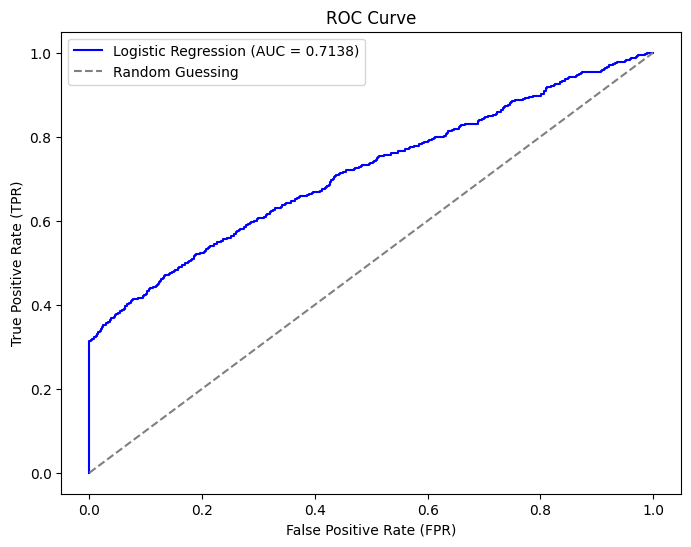

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib

# Step 1: Train Logistic Regression
print("\nStep 1: Training Logistic Regression model...")
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_balanced, y_train_balanced)

# Save the trained model for production use
model_filename = "logistic_regression_model_1.joblib"
joblib.dump(logreg, model_filename)
print(f"Model saved to {model_filename}")

# Step 2: Make predictions on the test set
print("Step 2: Making predictions...")
y_test_pred = logreg.predict(X_test)
y_test_probs = logreg.predict_proba(X_test)[:, 1]  # Probabilities for ROC/AUC

# Step 3: Evaluate Accuracy and Classification Report
print("\nStep 3: Evaluating performance...")
accuracy = accuracy_score(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_probs)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(report)

# Step 4: Calculate Equal Opportunity Accuracy (EO_AC)
# True positive rate and false negative rate for each class
positive_class = y_test[y_test == 1]
negative_class = y_test[y_test == 0]
positive_accuracy = accuracy_score(positive_class, y_test_pred[y_test == 1])
negative_accuracy = accuracy_score(negative_class, y_test_pred[y_test == 0])

eo_ac = (positive_accuracy + negative_accuracy) / 2
print(f"\nEqual Opportunity Accuracy (EO_AC): {eo_ac:.4f}")

# Step 5: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()


# RandomForestClassifier

In [ ]:
## Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Initialize the Random Forest Classifier
print("\nStep 1: Initializing the Random Forest Classifier...")
n_estimators=1000
random_state=42
rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
print(f"Random Forest model initialized with n_estimators={n_estimators} and random_state={random_state}.\n")

# Step 3: Split the data into training and testing sets
print("Step 3: Splitting the dataset into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)



# Step 2: Train the model on the balanced training dataset
print("Step 2: Training the Random Forest Classifier on the balanced training data...")
rf_model.fit(X_train_balanced, y_train_balanced)
print("Model training complete.\n")

# Save the trained model for production use
model_filename = "random_forest_model.joblib"
joblib.dump(rf_model, model_filename)
print(f"Model saved to {model_filename}")

# Step 3: Make predictions on the test dataset
print("Step 3: Making predictions on the test dataset...")
y_test_pred_rf = rf_model.predict(X_test)
print("Predictions complete.\n")

# Step 4: Evaluate the model performance
print("Step 4: Evaluating the model performance...")
accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
report_rf = classification_report(y_test, y_test_pred_rf)

# Step 5: Display the evaluation results
print("Step 5: Displaying evaluation results...")
print(f"Random Forest Model Accuracy: {accuracy_rf:.4f}\n")
print("Classification Report:")
print(report_rf)



Step 1: Initializing the Random Forest Classifier...
Random Forest model initialized with n_estimators=1000 and random_state=42.

Step 2: Training the Random Forest Classifier on the balanced training data...
Model training complete.

Model saved to random_forest_model.joblib
Step 3: Making predictions on the test dataset...
Predictions complete.

Step 4: Evaluating the model performance...
Step 5: Displaying evaluation results...
Random Forest Model Accuracy: 0.9024

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      4079
           1       0.89      0.35      0.50       664

    accuracy                           0.90      4743
   macro avg       0.90      0.67      0.72      4743
weighted avg       0.90      0.90      0.88      4743



In [ ]:
import pandas as pd
import numpy as np

# Step 1: Get feature importances
print("\nStep 1: Extracting feature importances from the trained Random Forest model...")
feature_importances = rf_model.feature_importances_

# Step 2: Map feature importances to column names
print("Step 2: Mapping feature importances to feature names...")
importance_df = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': feature_importances
})

# Step 3: Sort features by importance
print("Step 3: Sorting features by importance...")
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 10 features
print("\nTop 10 most important features:")
print(importance_df.head(10))

# Optional: Filter the top N features based on a threshold or rank
n_top_features = 30
top_features = importance_df.head(n_top_features)['Feature'].tolist()

print(f"\nTop {n_top_features} features (based on importance):")
for feature in top_features:
    print(f"{feature}")

# Step 4: Optionally create a new dataset with only the top N features
print("\nStep 4: Creating a new dataset with only the top features...")
X_train_top = X_train_balanced[top_features]
X_test_top = X_test[top_features]

print(f"Shape of new training dataset: {X_train_top.shape}")
print(f"Shape of new test dataset: {X_test_top.shape}")



Step 1: Extracting feature importances from the trained Random Forest model...
Step 2: Mapping feature importances to feature names...
Step 3: Sorting features by importance...

Top 10 most important features:
       Feature  Importance
4   r5oophos1y    0.108360
37   r5fallnum    0.042675
65  r5uppermob    0.041568
12    r5mobila    0.037475
79    r5adla_m    0.034944
66    r5grossa    0.034291
54    r5lgmusa    0.029778
39   r5oopmd1y    0.029137
38  r5lowermob    0.028771
55  r5mobilsev    0.027215

Top 30 features (based on importance):
r5oophos1y
r5fallnum
r5uppermob
r5mobila
r5adla_m
r5grossa
r5lgmusa
r5oopmd1y
r5lowermob
r5mobilsev
r5nagi8
r5nagi10
r5adltot6
r5adlfive
r5iwm
r5adla
r5lsatsc3
r5iadlfour
r5finea
r5bmi
r5height
r5adlwa
r5dentim1y
r5wtresp
r5ser7
r5wthh
raedyrs
r5weight
r5momage
rabyear

Step 4: Creating a new dataset with only the top features...
Shape of new training dataset: (19032, 30)
Shape of new test dataset: (4743, 30)


In [ ]:
# Save the top features for future use
features_filename = "top30_features.joblib"
joblib.dump(top_features, features_filename)
print(f"\nTop {n_top_features} features saved to {features_filename}")


Top 30 features saved to top30_features.joblib


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Filter the top N features based on a threshold or rank
n_top_features = 10
top_features = importance_df.head(n_top_features)['Feature'].tolist()

print(f"\nTop {n_top_features} features (based on importance):")
for feature in top_features:
    print(f"{feature}")

# Step 4: Optionally create a new dataset with only the top N features
print("\nStep 4: Creating a new dataset with only the top features...")
X_train_top = X_train_balanced[top_features]
X_test_top = X_test[top_features]

print(f"Shape of new training dataset: {X_train_top.shape}")
print(f"Shape of new test dataset: {X_test_top.shape}")



# Step 1: Define and Train the Logistic Regression Model
print(f"\nStep 1: Training Logistic Regression with Top {n_top_features} Features...")
log_reg = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)
log_reg.fit(X_train_top, y_train_balanced)

# Save the trained model for production use
model_filename = "logistic_regression_model_2.joblib"
joblib.dump(logreg, model_filename)
print(f"Model saved to {model_filename}")


# Step 2: Make Predictions
print("\nStep 2: Making Predictions...")
y_pred_train = log_reg.predict(X_train_top)
y_pred_test = log_reg.predict(X_test_top)

# Step 3: Evaluate Model Performance
print("\nStep 3: Evaluating Model Performance...")

# Training accuracy
train_accuracy = accuracy_score(y_train_balanced, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))



Top 10 features (based on importance):
r5oophos1y
r5fallnum
r5uppermob
r5mobila
r5adla_m
r5grossa
r5lgmusa
r5oopmd1y
r5lowermob
r5mobilsev

Step 4: Creating a new dataset with only the top features...
Shape of new training dataset: (19032, 10)
Shape of new test dataset: (4743, 10)

Step 1: Training Logistic Regression with Top 10 Features...
Model saved to logistic_regression_model_2.joblib

Step 2: Making Predictions...

Step 3: Evaluating Model Performance...
Training Accuracy: 0.7351
Test Accuracy: 0.8081

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      4079
           1       0.38      0.59      0.46       664

    accuracy                           0.81      4743
   macro avg       0.65      0.72      0.67      4743
weighted avg       0.85      0.81      0.82      4743


Confusion Matrix:
[[3442  637]
 [ 273  391]]


In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Step 1: Filter the Top N Features
n_top_features = 30
top_features = importance_df.head(n_top_features)['Feature'].tolist()

print(f"\nTop {n_top_features} features (based on importance):")
for feature in top_features:
    print(f"{feature}")

# Step 2: Create a new dataset with only the top features
print("\nStep 2: Creating a new dataset with only the top features...")
X_train_top = X_train_balanced[top_features]
X_test_top = X_test[top_features]

print(f"Shape of new training dataset: {X_train_top.shape}")
print(f"Shape of new test dataset: {X_test_top.shape}")

# Step 3: Apply SMOTE to balance the dataset
print("\nStep 3: Applying SMOTE for class balancing...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_top, y_train_balanced)

print(f"New class distribution: {dict(pd.Series(y_train_resampled).value_counts())}")

# Step 4: Apply Feature Scaling
print("\nStep 4: Scaling Features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test_top)

# Step 5: Optimize Logistic Regression for Recall
print("\nStep 5: Optimizing Logistic Regression using GridSearchCV...")
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=10000, random_state=42),
                           param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_resampled)

# Get the best model
log_reg = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

# Save the trained model for production use
model_filename = "logistic_regression_model_optimized.joblib"
joblib.dump(log_reg, model_filename)
print(f"Model saved to {model_filename}")

# Step 6: Make Predictions
print("\nStep 6: Making Predictions...")
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)

# Step 7: Evaluate Model Performance
print("\nStep 7: Evaluating Model Performance...")

# Training accuracy
train_accuracy = accuracy_score(y_train_resampled, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Initial Classification Report (without threshold adjustment)
print("\nInitial Classification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

# Initial Confusion Matrix
print("\nInitial Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

# Step 8: Adjust Decision Threshold for Higher Recall
print("\nStep 8: Adjusting Decision Threshold for Higher Recall...")
y_probs = log_reg.predict_proba(X_test_scaled)[:, 1]  # Get probability scores for class 1

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold where recall reaches 80% or higher
optimal_idx = np.argmax((recalls >= 0.80) & (precisions >= 0.50)) # First index where recall >= 80%
best_threshold = thresholds[idx] if idx < len(thresholds) else 0.5
print(f"New threshold for class 1: {best_threshold:.2f}")

# Apply new threshold
y_pred_adjusted = (y_probs >= best_threshold).astype(int)

# Step 9: Evaluate Model Performance After Threshold Adjustment
print("\nStep 9: Evaluating Model Performance After Threshold Adjustment...")

print("\nFinal Classification Report (Test Data) with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

# Final Confusion Matrix
print("\nFinal Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_adjusted))


Top 30 features (based on importance):
r5oophos1y
r5fallnum
r5uppermob
r5mobila
r5adla_m
r5grossa
r5lgmusa
r5oopmd1y
r5lowermob
r5mobilsev
r5nagi8
r5nagi10
r5adltot6
r5adlfive
r5iwm
r5adla
r5lsatsc3
r5iadlfour
r5finea
r5bmi
r5height
r5adlwa
r5dentim1y
r5wtresp
r5ser7
r5wthh
raedyrs
r5weight
r5momage
rabyear

Step 2: Creating a new dataset with only the top features...
Shape of new training dataset: (19032, 30)
Shape of new test dataset: (4743, 30)

Step 3: Applying SMOTE for class balancing...
New class distribution: {0: 9516, 1: 9516}

Step 4: Scaling Features...

Step 5: Optimizing Logistic Regression using GridSearchCV...
Best parameters found: {'C': 100, 'solver': 'liblinear'}
Model saved to logistic_regression_model_optimized.joblib

Step 6: Making Predictions...

Step 7: Evaluating Model Performance...
Training Accuracy: 0.7350
Test Accuracy: 0.7961

Initial Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.92      0.8

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



ROC AUC Score: 0.7762


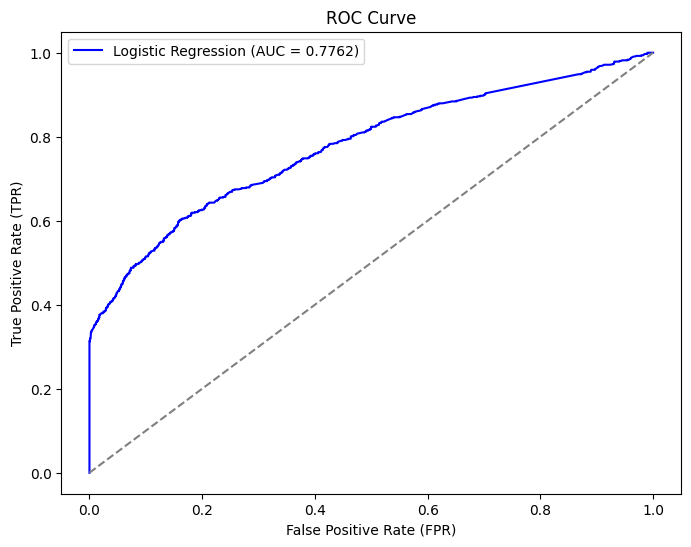

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probs_test = log_reg.predict_proba(X_test_top)[:, 1]  # Get probability for class 1

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_probs_test)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_probs_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal baseline
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.show()



# XGBOOST



In [ ]:
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Filter the Top N Features
n_top_features = 100
top_features = importance_df.head(n_top_features)['Feature'].tolist()

print(f"\nTop {n_top_features} features (based on importance):")
for feature in top_features:
    print(f"{feature}")

# Step 2: Create a new dataset with only the top features
print("\nStep 2: Creating a new dataset with only the top features...")
X_train_top = X_train_balanced[top_features]
X_test_top = X_test[top_features]

print(f"Shape of new training dataset: {X_train_top.shape}")
print(f"Shape of new test dataset: {X_test_top.shape}")

# Step 3: Define and Train the XGBoost Model
print(f"\nStep 3: Training XGBoost with Top {n_top_features} Features...")

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_top, y_train_balanced)

# Save the trained model for production use
model_filename = "xgboost_model_2.joblib"
joblib.dump(xgb_model, model_filename)
print(f"Model saved to {model_filename}")

# Step 4: Make Predictions
print("\nStep 4: Making Predictions...")
y_pred_train = xgb_model.predict(X_train_top)
y_pred_test = xgb_model.predict(X_test_top)

# Step 5: Evaluate Model Performance
print("\nStep 5: Evaluating Model Performance...")

# Training accuracy
train_accuracy = accuracy_score(y_train_balanced, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Top 100 features (based on importance):
r5oophos1y
r5fallnum
r5uppermob
r5mobila
r5adla_m
r5grossa
r5lgmusa
r5oopmd1y
r5lowermob
r5mobilsev
r5nagi8
r5nagi10
r5adltot6
r5adlfive
r5iwm
r5adla
r5lsatsc3
r5iadlfour
r5finea
r5bmi
r5height
r5adlwa
r5dentim1y
r5wtresp
r5ser7
r5wthh
raedyrs
r5weight
r5momage
rabyear
r5agey
rabmonth
r5dadage
raevbrn
r5ddraw1
r5decsib
r5vscan
r5cesd_m
r5livpar
r5uppermobm
r5livsib
r5tr16
r5verbf
r5dlrc8
r5imrc8
r5iadlfourm
r5mrct
r5idraw1
r5henum
r5lgmusam
r5oopdoc1y
r5oopden1y
r5ipent
r5igxfr
r5ipubpen
r5isret
r5nagi8m
r5iearn
r5adlwam
r5fineam
r5satlifez
r5adlam
r5adlfivem
r5adltot6m
r5mobilsevm
r5nagi10m
r5drinkd
r5drinkn
r5lowermobm
r5ipeno
r5mobilam
r5cesdm_m
r5binged
r5smokef
r5grossam
r5lsatsc3m
r5ooposrg1y
r5iothr
r5iwy
r5issdi
r5ipena
r5ipubo
r5adlam_m
r5iwstat
r5iwf

Step 2: Creating a new dataset with only the top features...
Shape of new training dataset: (19032, 85)
Shape of new test dataset: (4743, 85)

Step 3: Training XGBoost with Top 100 Featur

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:05:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved to xgboost_model_2.joblib

Step 4: Making Predictions...

Step 5: Evaluating Model Performance...
Training Accuracy: 0.9711
Test Accuracy: 0.9017

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      4079
           1       0.88      0.34      0.50       664

    accuracy                           0.90      4743
   macro avg       0.89      0.67      0.72      4743
weighted avg       0.90      0.90      0.88      4743


Confusion Matrix:
[[4048   31]
 [ 435  229]]


# SGDClassifier


In [ ]:
import joblib
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Filter the Top N Features
n_top_features = 10
top_features = importance_df.head(n_top_features)['Feature'].tolist()

print(f"\nTop {n_top_features} features (based on importance):")
for feature in top_features:
    print(f"{feature}")

# Step 2: Create a new dataset with only the top features
print("\nStep 2: Creating a new dataset with only the top features...")
X_train_top = X_train_balanced[top_features]
X_test_top = X_test[top_features]

print(f"Shape of new training dataset: {X_train_top.shape}")
print(f"Shape of new test dataset: {X_test_top.shape}")

# Step 3: Define and Train the SGD Classifier
print(f"\nStep 3: Training SGDClassifier with Top {n_top_features} Features...")

sgd_model = SGDClassifier(
    loss="log_loss",  # Logistic Regression (for binary classification)
    penalty="l2",  # Ridge regularization
    max_iter=1000,  # Number of iterations
    alpha=0.0001,  # Regularization strength
    random_state=42
)

sgd_model.fit(X_train_top, y_train_balanced)

# Save the trained model for production use
model_filename = "sgd_classifier_model.joblib"
joblib.dump(sgd_model, model_filename)
print(f"Model saved to {model_filename}")

# Step 4: Make Predictions
print("\nStep 4: Making Predictions...")
y_pred_train = sgd_model.predict(X_train_top)
y_pred_test = sgd_model.predict(X_test_top)

# Step 5: Evaluate Model Performance
print("\nStep 5: Evaluating Model Performance...")

# Training accuracy
train_accuracy = accuracy_score(y_train_balanced, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Top 10 features (based on importance):
r5oophos1y
r5fallnum
r5uppermob
r5mobila
r5adla_m
r5grossa
r5lgmusa
r5oopmd1y
r5lowermob
r5mobilsev

Step 2: Creating a new dataset with only the top features...
Shape of new training dataset: (19032, 10)
Shape of new test dataset: (4743, 10)

Step 3: Training SGDClassifier with Top 10 Features...
Model saved to sgd_classifier_model.joblib

Step 4: Making Predictions...

Step 5: Evaluating Model Performance...
Training Accuracy: 0.7084
Test Accuracy: 0.8429

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4079
           1       0.44      0.47      0.46       664

    accuracy                           0.84      4743
   macro avg       0.68      0.69      0.68      4743
weighted avg       0.85      0.84      0.85      4743


Confusion Matrix:
[[3684  395]
 [ 350  314]]


In [ ]:
features_dict = {
    "r5hspnit1y": {"variable_explanation": "Hospital nights, previous 12 months", "variable_type": "Cont"},
    "r5oophos1y": {"variable_explanation": "Out of pocket hospital exp", "variable_type": "Cont"},
    "r5doctim1y": {"variable_explanation": "# Doctor visits, previous 12 months", "variable_type": "Cont"},
    "r5adla_m": {"variable_explanation": "Some difficulty-ADLs 0-4", "variable_type": "Cont"},
    "r5grossa": {"variable_explanation": "Some difficulty-Gross Motor 0-5", "variable_type": "Cont"},
    "r5uppermob": {"variable_explanation": "Some difficulty-Upper Body Mobility 0-3", "variable_type": "Cont"},
    "r5fallnum": {"variable_explanation": "Number of falls", "variable_type": "Cont"},
    "r5mobila": {"variable_explanation": "Some difficulty-Mobility 0-5", "variable_type": "Cont"},
    "r5lowermob": {"variable_explanation": "Some difficulty-Missings in Lower Body Mob", "variable_type": "Cont"},
    "r5nagi10": {"variable_explanation": "Some difficulty-NAGI Score 0-10", "variable_type": "Cont"},
    "r5mobilsev": {"variable_explanation": "Some difficulty-7 item Mobility 0-7", "variable_type": "Cont"},
    "r5adla": {"variable_explanation": "Some difficulty-ADLs 0-5", "variable_type": "Cont"},
    "r5adltot6": {"variable_explanation": "Some difficulty-Total ADLs 0-6", "variable_type": "Cont"},
    "r5lgmusa": {"variable_explanation": "Some difficulty-Large Muscle 0-4", "variable_type": "Cont"},
    "r5oopmd1y": {"variable_explanation": "Out of pocket med exp, previous 12 months", "variable_type": "Cont"},
    "r5iadlfour": {"variable_explanation": "Some difficulty-IADLs 0-4", "variable_type": "Cont"},
    "r5nagi8": {"variable_explanation": "Some difficulty-NAGI Score 0-8", "variable_type": "Cont"},
    "r5adlfive": {"variable_explanation": "Some difficulty-ADLs 0-5 Alternate", "variable_type": "Cont"},
    "r5lsatsc3": {"variable_explanation": "Satisfaction with life scale score", "variable_type": "Cont"},
    "r5iwm": {"variable_explanation": "Interview Month", "variable_type": "Cont"},
    "r5adlwa": {"variable_explanation": "Some difficulty-ADLs: Wallace 0-3", "variable_type": "Cont"},
    "r5finea": {"variable_explanation": "Some difficulty-Fine Motor 0-3", "variable_type": "Cont"},
    "r5dentim1y": {"variable_explanation": "Dental visits, previous 12 months", "variable_type": "Cont"},
    "r5fineam": {"variable_explanation": "Some difficulty-Missings in Fine Motor Score", "variable_type": "Cont"},
    "r5uppermobm": {"variable_explanation": "Some difficulty-Missings in Upper Body Mob", "variable_type": "Cont"},
    "r5height": {"variable_explanation": "Height in meters", "variable_type": "Cont"},
    "r5ser7": {"variable_explanation": "Serial 7's number of correct subtractions", "variable_type": "Cont"},
    "r5bmi": {"variable_explanation": "Body Mass Index=kg/m2", "variable_type": "Cont"},
    "r5nagi8m": {"variable_explanation": "Some difficulty-Missings in 8-item NAGI Score", "variable_type": "Cont"},
    "raedyrs": {"variable_explanation": "Years of Education", "variable_type": "Cont"}
}

# Print the dictionary to verify
print(features_dict)


{'r5hspnit1y': {'variable_explanation': 'Hospital nights, previous 12 months', 'variable_type': 'Cont'}, 'r5oophos1y': {'variable_explanation': 'Out of pocket hospital exp', 'variable_type': 'Cont'}, 'r5doctim1y': {'variable_explanation': '# Doctor visits, previous 12 months', 'variable_type': 'Cont'}, 'r5adla_m': {'variable_explanation': 'Some difficulty-ADLs 0-4', 'variable_type': 'Cont'}, 'r5grossa': {'variable_explanation': 'Some difficulty-Gross Motor 0-5', 'variable_type': 'Cont'}, 'r5uppermob': {'variable_explanation': 'Some difficulty-Upper Body Mobility 0-3', 'variable_type': 'Cont'}, 'r5fallnum': {'variable_explanation': 'Number of falls', 'variable_type': 'Cont'}, 'r5mobila': {'variable_explanation': 'Some difficulty-Mobility 0-5', 'variable_type': 'Cont'}, 'r5lowermob': {'variable_explanation': 'Some difficulty-Missings in Lower Body Mob', 'variable_type': 'Cont'}, 'r5nagi10': {'variable_explanation': 'Some difficulty-NAGI Score 0-10', 'variable_type': 'Cont'}, 'r5mobilsev'

# KNeighborsClassifier

In [ ]:
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Filter the Top N Features
n_top_features = 20
top_features = importance_df.head(n_top_features)['Feature'].tolist()

print(f"\nTop {n_top_features} features (based on importance):")
for feature in top_features:
    print(f"{feature}")

# Step 2: Create a new dataset with only the top features
print("\nStep 2: Creating a new dataset with only the top features...")
X_train_top = X_train_balanced[top_features]
X_test_top = X_test[top_features]

print(f"Shape of new training dataset: {X_train_top.shape}")
print(f"Shape of new test dataset: {X_test_top.shape}")

# Step 3: Define and Train the KNN Classifier
print(f"\nStep 3: Training KNN with Top {n_top_features} Features...")

knn_model = KNeighborsClassifier(
    n_neighbors=3,  # Default is 5, but you can tune this
    weights='distance',  # All neighbors contribute equally
    metric='minkowski',  # Euclidean distance (default)
    n_jobs=-1  # Use all available CPU cores for parallel processing
)

knn_model.fit(X_train_top, y_train_balanced)

# Save the trained model for production use
model_filename = "knn_classifier_model.joblib"
joblib.dump(knn_model, model_filename)
print(f"Model saved to {model_filename}")

# Step 4: Make Predictions
print("\nStep 4: Making Predictions...")
y_pred_train = knn_model.predict(X_train_top)
y_pred_test = knn_model.predict(X_test_top)

# Step 5: Evaluate Model Performance
print("\nStep 5: Evaluating Model Performance...")

# Training accuracy
train_accuracy = accuracy_score(y_train_balanced, y_pred_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))


Top 20 features (based on importance):
r5oophos1y
r5fallnum
r5uppermob
r5mobila
r5adla_m
r5grossa
r5lgmusa
r5oopmd1y
r5lowermob
r5mobilsev
r5nagi8
r5nagi10
r5adltot6
r5adlfive
r5iwm
r5adla
r5lsatsc3
r5iadlfour
r5finea
r5bmi

Step 2: Creating a new dataset with only the top features...
Shape of new training dataset: (19032, 20)
Shape of new test dataset: (4743, 20)

Step 3: Training KNN with Top 20 Features...
Model saved to knn_classifier_model.joblib

Step 4: Making Predictions...

Step 5: Evaluating Model Performance...
Training Accuracy: 0.9982
Test Accuracy: 0.7805

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      4079
           1       0.32      0.48      0.38       664

    accuracy                           0.78      4743
   macro avg       0.61      0.66      0.62      4743
weighted avg       0.82      0.78      0.80      4743


Confusion Matrix:
[[3381  698]
 [ 343  321]]


In [ ]:
for i, (key, value) in enumerate(features_dict.items(), start=1):
    print(f"{i}. Variable: {key}")
    print(f"   Explanation: {value['variable_explanation']}")
    print(f"   Type: {value['variable_type']}")
    print("-" * 50)


1. Variable: r5hspnit1y
   Explanation: Hospital nights, previous 12 months
   Type: Cont
--------------------------------------------------
2. Variable: r5oophos1y
   Explanation: Out of pocket hospital exp
   Type: Cont
--------------------------------------------------
3. Variable: r5doctim1y
   Explanation: # Doctor visits, previous 12 months
   Type: Cont
--------------------------------------------------
4. Variable: r5adla_m
   Explanation: Some difficulty-ADLs 0-4
   Type: Cont
--------------------------------------------------
5. Variable: r5grossa
   Explanation: Some difficulty-Gross Motor 0-5
   Type: Cont
--------------------------------------------------
6. Variable: r5uppermob
   Explanation: Some difficulty-Upper Body Mobility 0-3
   Type: Cont
--------------------------------------------------
7. Variable: r5fallnum
   Explanation: Number of falls
   Type: Cont
--------------------------------------------------
8. Variable: r5mobila
   Explanation: Some difficulty-Mobi

In [ ]:
features_explanations = {
    "r5hspnit1y": "Previous hospitalizations indicate chronic conditions or frequent healthcare needs.",
    "r5oophos1y": "Higher out-of-pocket hospital expenses may indicate severe past illnesses.",
    "r5doctim1y": "Frequent doctor visits suggest ongoing medical issues requiring care.",
    "r5adla_m": "ADL difficulty shows reduced independence, linked to frailty and hospitalization.",
    "r5grossa": "Gross motor difficulty may indicate neuromuscular disorders or fall risk.",
    "r5uppermob": "Upper mobility issues can signal neuromuscular decline or severe arthritis.",
    "r5fallnum": "A higher number of falls is associated with injuries and hospitalization risk.",
    "r5mobila": "General mobility difficulties predict dependency and potential health decline.",
    "r5lowermob": "Lower body mobility issues increase fall and injury risks.",
    "r5nagi10": "NAGI score assesses physical function; lower scores suggest increased frailty.",
    "r5mobilsev": "Severe mobility impairment is linked to chronic disease and hospitalization.",
    "r5adla": "ADL difficulties indicate dependency, which increases hospitalization likelihood.",
    "r5adltot6": "Total ADL limitations reflect overall physical decline and care needs.",
    "r5lgmusa": "Large muscle difficulty can signal progressive conditions like Parkinson’s.",
    "r5oopmd1y": "High medication costs indicate chronic disease and higher healthcare needs.",
    "r5iadlfour": "IADL difficulties suggest cognitive or physical decline, leading to hospitalization.",
    "r5nagi8": "Lower NAGI scores predict limited physical ability and health risks.",
    "r5adlfive": "Another ADL measure showing functional limitations linked to hospitalization.",
    "r5lsatsc3": "Low life satisfaction may correlate with chronic illness or mental health decline.",
    "r5iwm": "Interview month may help adjust for seasonal hospitalization trends.",
    "r5adlwa": "Wallace ADL score measures functional decline, a key hospitalization predictor.",
    "r5finea": "Fine motor difficulty may indicate neurological conditions affecting independence.",
    "r5dentim1y": "Dental visits show health awareness; poor oral health may signal systemic issues.",
    "r5fineam": "Fine motor impairments can impact self-care and indicate neurological decline.",
    "r5uppermobm": "Upper mobility issues may indicate stroke or musculoskeletal problems.",
    "r5height": "Height may relate to frailty; shorter individuals may have higher hospitalization risk.",
    "r5ser7": "Serial 7’s test assesses cognition; poor results may indicate cognitive decline.",
    "r5bmi": "BMI outside the normal range is linked to obesity, malnutrition, or chronic illness.",
    "r5nagi8m": "Missings in NAGI scores may indicate underlying health disparities.",
    "raedyrs": "Lower education levels are linked to poorer health literacy and outcomes."
}

for i, (key, explanation) in enumerate(features_explanations.items(), start=1):
    print(f"{i}. Variable: {key}")
    print(f"   Short Explanation: {explanation}")
    print("-" * 80)


1. Variable: r5hspnit1y
   Short Explanation: Previous hospitalizations indicate chronic conditions or frequent healthcare needs.
--------------------------------------------------------------------------------
2. Variable: r5oophos1y
   Short Explanation: Higher out-of-pocket hospital expenses may indicate severe past illnesses.
--------------------------------------------------------------------------------
3. Variable: r5doctim1y
   Short Explanation: Frequent doctor visits suggest ongoing medical issues requiring care.
--------------------------------------------------------------------------------
4. Variable: r5adla_m
   Short Explanation: ADL difficulty shows reduced independence, linked to frailty and hospitalization.
--------------------------------------------------------------------------------
5. Variable: r5grossa
   Short Explanation: Gross motor difficulty may indicate neuromuscular disorders or fall risk.
-----------------------------------------------------------------

### **1. Medical History**
These variables reflect the frequency of healthcare interactions and can indicate chronic conditions or the need for frequent medical attention.

| Variable       | Short Explanation |
|---------------|------------------|
| **r5hspnit1y** | Previous hospitalizations suggest chronic conditions or frequent medical needs. |
| **r5oophos1y** | High out-of-pocket hospital expenses may indicate severe illnesses or costly treatments. |
| **r5doctim1y** | Frequent doctor visits suggest ongoing medical issues requiring continuous care. |
| **r5oopmd1y** | High medication expenses indicate multiple chronic conditions. |
| **r5dentim1y** | Dental visits show health awareness, while lack of visits may indicate systemic issues. |

---

### **2. Mobility and Physical Function**
These variables reflect a person’s physical ability. Reduced mobility and functionality predict a higher risk of hospitalization due to falls, fractures, and dependency.

| Variable       | Short Explanation |
|---------------|------------------|
| **r5adla_m** | Difficulty with Activities of Daily Living (ADLs) indicates growing dependency. |
| **r5grossa** | Gross motor difficulties reflect muscle weakness and increased fall risk. |
| **r5uppermob** | Upper body mobility issues may affect essential daily tasks. |
| **r5fallnum** | Frequent falls are a strong predictor of hospitalization and fractures. |
| **r5mobila** | General mobility difficulties may indicate neurodegenerative diseases. |
| **r5lowermob** | Lower body mobility issues increase the risk of falls and injuries. |
| **r5mobilsev** | Severe mobility impairment is associated with chronic disease progression. |
| **r5lgmusa** | Large muscle difficulties may indicate conditions such as multiple sclerosis. |

---

### **3. Functional Dependency and Cognitive Difficulties**
These variables indicate physical and cognitive limitations, which increase the likelihood of hospitalization.

| Variable       | Short Explanation |
|---------------|------------------|
| **r5adla** | More ADL difficulties predict greater dependency and hospitalization risk. |
| **r5adltot6** | Total ADL score measures overall functionality and care needs. |
| **r5iadlfour** | Difficulty with Instrumental ADLs (IADLs) may indicate cognitive or physical decline. |
| **r5adlfive** | Alternate ADL measure showing independence in basic activities. |
| **r5adlwa** | Wallace ADL score, another indicator of functional decline and hospitalization risk. |
| **r5finea** | Fine motor difficulties may signal neurological conditions. |
| **r5fineam** | Loss of fine motor skills affects independence in daily activities. |

---

### **4. Cognitive and Psychological Factors**
These variables measure a person’s mental and emotional state. Cognitive and emotional issues can increase vulnerability to illness and hospitalization.

| Variable       | Short Explanation |
|---------------|------------------|
| **r5nagi10** | Physical function assessment; lower scores indicate increased frailty. |
| **r5nagi8** | A variation of the NAGI score, related to physical functionality. |
| **r5nagi8m** | Missing NAGI scores may indicate underlying health disparities. |
| **r5lsatsc3** | Low life satisfaction may be associated with chronic illness or depression. |
| **r5ser7** | Serial 7s cognitive test; poor performance may indicate cognitive decline. |

---

### **5. Demographic and Anthropometric Factors**
These variables provide information on physical and educational characteristics, which can influence health and hospitalization risk.

| Variable       | Short Explanation |
|---------------|------------------|
| **r5iwm** | Interview month may help adjust for seasonal hospitalization trends. |
| **r5uppermobm** | Upper mobility difficulties may indicate stroke or musculoskeletal disorders. |
| **r5height** | Height may relate to frailty; shorter individuals may have higher hospitalization risk. |
| **r5bmi** | BMI outside the normal range is linked to obesity, malnutrition, or chronic illness. |
| **raedyrs** | Fewer years of education correlate with lower health literacy and worse health outcomes. |

---

### **Conclusion**
These variables help predict hospitalizations due to:
1. **Medical history:** People with multiple doctor visits and previous hospitalizations have a higher risk.
2. **Mobility and functionality:** Reduced ability to move and perform daily tasks increases vulnerability.
3. **Dependency and cognitive decline:** Loss of independence and mental deterioration can lead to situations requiring hospitalization.
4. **Psychological factors:** Low life satisfaction and cognitive impairment can affect physical health.
5. **Physical and educational factors:** Physical characteristics and education levels influence general health and access to care.


### **ADL (Activities of Daily Living)**  
ADL refers to **basic self-care activities** that individuals need to perform daily to live independently. These activities are often used to assess functional status, particularly in older adults or people with disabilities.  

There are **two types** of ADLs:  

1. **Basic ADLs (BADLs)** – These are fundamental self-care tasks:
   - Bathing
   - Dressing
   - Eating
   - Using the toilet
   - Transferring (e.g., moving from bed to chair)
   - Walking or moving around  

2. **Instrumental ADLs (IADLs)** – These are more complex tasks that require cognitive and physical abilities:
   - Managing finances
   - Cooking and meal preparation
   - Shopping for groceries
   - Housekeeping
   - Using transportation
   - Managing medications  

A decline in ADLs suggests **functional impairment**, which increases the likelihood of hospitalization, nursing home admission, and long-term care needs.  

---

### **NAGI (Nagi Disability Scale)**  
The **Nagi Scale** is a measure of **functional limitations** and **disability** related to physical movement. It is named after **Saad Nagi**, a sociologist who studied disability.  

The scale assesses **difficulty in performing specific physical tasks**, such as:  
- Walking long distances  
- Climbing stairs  
- Lifting heavy objects  
- Reaching overhead  
- Gripping small objects  
- Stooping or kneeling  

The **NAGI score** is often used in research to predict disability progression, hospitalization risk, and overall physical decline. **Higher difficulty in NAGI tasks is associated with greater frailty and risk of needing medical intervention.**  

---

### **How ADL and NAGI Predict Hospitalization**  
- **ADL impairment** → Suggests loss of independence and increased vulnerability to accidents, infections, and complications.  
- **High NAGI scores** → Indicate limited physical function, which can lead to falls, immobility, and hospital admissions.  

Both measures are commonly used in **geriatrics, rehabilitation, and disability assessments** to determine care needs and predict health outcomes.

In [ ]:
# Load the saved top features and category mappings

# top_features = joblib.load("top_features.joblib")

top_features = importance_df.head(n_top_features)['Feature'].tolist()
category_mappings = joblib.load("category_mappings.joblib")

# Get only categorical features from the top 30 features
categorical_top_features = [col for col in top_features if col in category_mappings]

# Display possible values for each categorical feature in the top 30
print("\nPossible values for categorical features in the top 30:")
for feature in categorical_top_features:
    print(f"{feature}: {category_mappings[feature]}")



Possible values for categorical features in the top 30:


In [ ]:
import pandas as pd

# Assuming `final_data` is the original dataset
clean_data = final_data.copy()
top_features = importance_df.head(n_top_features)['Feature'].tolist()

features_dict = {
    "r5hspnit1y": {"variable_explanation": "Hospital nights, previous 12 months", "variable_type": "Cont"},
    "r5oophos1y": {"variable_explanation": "Out of pocket hospital exp", "variable_type": "Cont"},
    "r5doctim1y": {"variable_explanation": "# Doctor visits, previous 12 months", "variable_type": "Cont"},
    "r5adla_m": {"variable_explanation": "Some difficulty-ADLs 0-4", "variable_type": "Cont"},
    "r5grossa": {"variable_explanation": "Some difficulty-Gross Motor 0-5", "variable_type": "Cont"},
    "r5uppermob": {"variable_explanation": "Some difficulty-Upper Body Mobility 0-3", "variable_type": "Cont"},
    "r5fallnum": {"variable_explanation": "Number of falls", "variable_type": "Cont"},
    "r5mobila": {"variable_explanation": "Some difficulty-Mobility 0-5", "variable_type": "Cont"},
    "r5lowermob": {"variable_explanation": "Some difficulty-Missings in Lower Body Mob", "variable_type": "Cont"},
    "r5nagi10": {"variable_explanation": "Some difficulty-NAGI Score 0-10", "variable_type": "Cont"},
    "r5mobilsev": {"variable_explanation": "Some difficulty-7 item Mobility 0-7", "variable_type": "Cont"},
    "r5adla": {"variable_explanation": "Some difficulty-ADLs 0-5", "variable_type": "Cont"},
    "r5adltot6": {"variable_explanation": "Some difficulty-Total ADLs 0-6", "variable_type": "Cont"},
    "r5lgmusa": {"variable_explanation": "Some difficulty-Large Muscle 0-4", "variable_type": "Cont"},
    "r5oopmd1y": {"variable_explanation": "Out of pocket med exp, previous 12 months", "variable_type": "Cont"},
    "r5iadlfour": {"variable_explanation": "Some difficulty-IADLs 0-4", "variable_type": "Cont"},
    "r5nagi8": {"variable_explanation": "Some difficulty-NAGI Score 0-8", "variable_type": "Cont"},
    "r5adlfive": {"variable_explanation": "Some difficulty-ADLs 0-5 Alternate", "variable_type": "Cont"},
    "r5lsatsc3": {"variable_explanation": "Satisfaction with life scale score", "variable_type": "Cont"},
    "r5iwm": {"variable_explanation": "Interview Month", "variable_type": "Cont"},
    "r5adlwa": {"variable_explanation": "Some difficulty-ADLs: Wallace 0-3", "variable_type": "Cont"},
    "r5finea": {"variable_explanation": "Some difficulty-Fine Motor 0-3", "variable_type": "Cont"},
    "r5dentim1y": {"variable_explanation": "Dental visits, previous 12 months", "variable_type": "Cont"},
    "r5fineam": {"variable_explanation": "Some difficulty-Missings in Fine Motor Score", "variable_type": "Cont"},
    "r5uppermobm": {"variable_explanation": "Some difficulty-Missings in Upper Body Mob", "variable_type": "Cont"},
    "r5height": {"variable_explanation": "Height in meters", "variable_type": "Cont"},
    "r5ser7": {"variable_explanation": "Serial 7's number of correct subtractions", "variable_type": "Cont"},
    "r5bmi": {"variable_explanation": "Body Mass Index=kg/m2", "variable_type": "Cont"},
    "r5nagi8m": {"variable_explanation": "Some difficulty-Missings in 8-item NAGI Score", "variable_type": "Cont"},
    "raedyrs": {"variable_explanation": "Years of Education", "variable_type": "Cont"}
}

# Dictionary to store feature details
feature_details = []

for feature in top_features:
    unique_values = clean_data[feature].unique()
    unique_count = len(unique_values)
    min_value = clean_data[feature].min() if clean_data[feature].dtype != 'object' else None
    max_value = clean_data[feature].max() if clean_data[feature].dtype != 'object' else None
    feature_type = clean_data[feature].dtype
    variable_explanation = features_dict.get(feature, {}).get("variable_explanation", "Unknown")

    feature_details.append({
        "Feature": feature,
        "Variable Explanation": variable_explanation,
        "Type": feature_type,
        "Unique Values Count": unique_count,
        "Min Value": min_value,
        "Max Value": max_value,
        "Unique Values": unique_values
    })

# Convert to DataFrame for better visualization
feature_details_df = pd.DataFrame(feature_details)



In [ ]:
feature_details_df

,Feature,Variable Explanation,Type,Unique Values Count,Min Value,Max Value,Unique Values
0,r5oophos1y,Out of pocket hospital exp,float32,239,0.0,350000.000000,"[0.0, 4944.1934, 200.0, 4711.764, 700.0, 2000...."
1,r5fallnum,Number of falls,float64,29,-1.0,98.000000,"[0.0, 2.0, 4.0, 1.0, 3.0, 7.0, 5.0, 10.0, -1.0..."
2,r5uppermob,Some difficulty-Upper Body Mobility 0-3,float64,5,-1.0,3.000000,"[0.0, 1.0, 2.0, -1.0, 3.0]"
3,r5mobila,Some difficulty-Mobility 0-5,float64,7,-1.0,5.000000,"[1.0, 0.0, 2.0, 4.0, 3.0, -1.0, 5.0]"
4,r5adla_m,Some difficulty-ADLs 0-4,float64,6,-1.0,4.000000,"[0.0, 1.0, 4.0, 2.0, -1.0, 3.0]"
5,r5grossa,Some difficulty-Gross Motor 0-5,float64,7,-1.0,5.000000,"[0.0, 1.0, 2.0, -1.0, 3.0, 4.0, 5.0]"
6,r5lgmusa,Some difficulty-Large Muscle 0-4,float64,6,-1.0,4.000000,"[0.0, 2.0, 3.0, 1.0, -1.0, 4.0]"
7,r5oopmd1y,"Out of pocket med exp, previous 12 months",float32,1105,0.0,600000.000000,"[0.0, 5544.1934, 350.0, 8000.0, 200.0, 4500.0,..."
8,r5lowermob,Some difficulty-Missings in Lower Body Mob,float64,6,-1.0,4.000000,"[1.0, 0.0, 2.0, 3.0, 4.0, -1.0]"
9,r5mobilsev,Some difficulty-7 item Mobility 0-7,float64,9,-1.0,7.000000,"[1.0, 0.0, 3.0, 4.0, 2.0, 5.0, 6.0, -1.0, 7.0]"


In [ ]:
# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Select the top 25 features
top_25_features = feature_importance_df.head(30)['Feature'].tolist()

# Create a new dataset with only the top 25 features
X_train_selected = X_train_resampled[top_25_features]
X_test_selected = X_test[top_25_features]

# Train a new XGBoost model with the selected features
xgb_clf_selected = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]) * 2.5,  # Increase to give more weight to positives
    max_depth=6,
    learning_rate=0.03,  # Lower learning rate to improve learning of minority class
    n_estimators=300,  # Increase trees for better learning
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=1,  # Helps reduce false negatives
    min_child_weight=1,
    random_state=42
)
xgb_clf_selected.fit(X_train_selected, y_train_resampled)

# Get predictions for the new model
y_pred_selected = xgb_clf_selected.predict(X_test_selected)

# Evaluate the new model
print("Confusion Matrix (Top 25 Features):\n", confusion_matrix(y_test, y_pred_selected))
print("\nClassification Report (Top 25 Features):\n", classification_report(y_test, y_pred_selected, digits=4))

# Plot feature importance for the new model
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:25], feature_importance_df['Importance'][:25], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 25 Important Features in XGBoost")
plt.gca().invert_yaxis()
plt.show()


NameError: name 'pd' is not defined

In [ ]:
print("\nTop 25 Most Important Features:\n")
#print(feature_importance_df.head(25))

features_dict = {
    "r5oophos1y": {"variable_explanation": "Out of pocket hospital exp", "variable_type": "Cont"},
    "r5mobilaa": {"variable_explanation": "Any difficulty Mobility 0-5  ", "variable_type": "Categ"},
    "r5uppermoba": {"variable_explanation": "Any difficulty Upper Body Mobility 0-3", "variable_type": "Cont"},
    "r5fall": {"variable_explanation": "Fallen down last 2 years" , "variable_type": "Categ"},
    "r5inlbrf": {"variable_explanation": "In the Labor Force " , "variable_type": "Categ"},
    "r5adla_m": {"variable_explanation": "Some difficulty-ADLs 0-4", "variable_type": "Cont"},
    "r5adlaa": {"variable_explanation": "Any difficulty ADLs 0-5 ", "variable_type": "Categ"},
    "r5grossaa": {"variable_explanation": "Any difficulty Gross Motor 0-5  ", "variable_type": "Categ"},
    "r5adlaa_m": {"variable_explanation": "Any difficulty ADLs 0-4   ", "variable_type": "Categ"},
    "r5adlaa_m": {"variable_explanation": "Any difficulty ADLs 0-4   ", "variable_type": "Categ"},
    "r5mobila": {"variable_explanation": "Any difficulty Mobility 0-5 ", "variable_type": "Cont"},
    "r5mobilseva": {"variable_explanation": "Any difficulty Mobility 0-5 ", "variable_type": "Categ"},
    "r5uppermob": {"variable_explanation": "Some difficulty-Upper Body Mobility 0-3", "variable_type": "Cont"},
    "r5uppermobm": {"variable_explanation": "Some difficulty-Missings in Upper Body Mob", "variable_type": "Cont"},
    "r5fallnum": {"variable_explanation": "Number of falls", "variable_type": "Cont"},

    "r5dentim1y": {"variable_explanation": "Dental visits, previous 12 months", "variable_type": "Cont"},

    "r5lowermoba": {"variable_explanation": "Any difficulty Lower Body Mobility 0-4", "variable_type": "Categ"},
    "r5lbrf_m": {"variable_explanation": "Labor force status", "variable_type": "Categ"},
    "r5retemp": {"variable_explanation": "Retired employment status", "variable_type": "Categ"},
    "r5fallinj": {"variable_explanation": "Injured from fall", "variable_type": "Categ"},
    "r5drink": {"variable_explanation": "Ever drinks any alcohol ", "variable_type": "Categ"},
    "r5nagi8a": {"variable_explanation": "Any difficulty NAGI Score 0-8", "variable_type": "Categ"},
    "r5lgmusam": {"variable_explanation": "Some difficulty-Missings in Large Muscle Sco", "variable_type": "Cont"},
    "r5clim1a": {"variable_explanation": "Some difficulty-Climbing one flt stairs ", "variable_type": "Categ"},

    "r5grossa": {"variable_explanation": "Some difficulty-Gross Motor 0-5", "variable_type": "Cont"},



    "r5lowermob": {"variable_explanation": "Some difficulty-Missings in Lower Body Mob", "variable_type": "Cont"},
    "r5nagi10": {"variable_explanation": "Some difficulty-NAGI Score 0-10", "variable_type": "Cont"},
    "r5mobilsev": {"variable_explanation": "Some difficulty-7 item Mobility 0-7", "variable_type": "Cont"},
    "r5adla": {"variable_explanation": "Some difficulty-ADLs 0-5", "variable_type": "Cont"},
    "r5adltot6": {"variable_explanation": "Some difficulty-Total ADLs 0-6", "variable_type": "Cont"},
    "r5lgmusa": {"variable_explanation": "Some difficulty-Large Muscle 0-4", "variable_type": "Cont"},
    "r5oopmd1y": {"variable_explanation": "Out of pocket med exp, previous 12 months", "variable_type": "Cont"},
    "r5iadlfour": {"variable_explanation": "Some difficulty-IADLs 0-4", "variable_type": "Cont"},
    "r5nagi8": {"variable_explanation": "Some difficulty-NAGI Score 0-8", "variable_type": "Cont"},
    "r5adlfive": {"variable_explanation": "Some difficulty-ADLs 0-5 Alternate", "variable_type": "Cont"},
    "r5lsatsc3": {"variable_explanation": "Satisfaction with life scale score", "variable_type": "Cont"},
    "r5adlwa": {"variable_explanation": "Some difficulty-ADLs: Wallace 0-3", "variable_type": "Cont"},
    "r5finea": {"variable_explanation": "Some difficulty-Fine Motor 0-3", "variable_type": "Cont"},
    "r5dentim1y": {"variable_explanation": "Dental visits, previous 12 months", "variable_type": "Cont"},
    "r5fineam": {"variable_explanation": "Some difficulty-Missings in Fine Motor Score", "variable_type": "Cont"},

    "r5height": {"variable_explanation": "Height in meters", "variable_type": "Cont"},
    "r5ser7": {"variable_explanation": "Serial 7's number of correct subtractions", "variable_type": "Cont"},
    "r5bmi": {"variable_explanation": "Body Mass Index=kg/m2", "variable_type": "Cont"},
    "r5nagi8m": {"variable_explanation": "Some difficulty-Missings in 8-item NAGI Score", "variable_type": "Cont"},
    "raedyrs": {"variable_explanation": "Years of Education", "variable_type": "Cont"}
}




features_dict = {
    "r5adla": {"variable_explanation": "Some difficulty-ADLs 0-5", "variable_type": "Cont"},
    "r5adltot6": {"variable_explanation": "Some difficulty-Total ADLs 0-6", "variable_type": "Cont"},
    "r5iadlfour": {"variable_explanation": "Some difficulty-IADLs 0-4", "variable_type": "Cont"},
    "r5nagi8": {"variable_explanation": "Some difficulty-NAGI Score 0-8", "variable_type": "Cont"},
    "r5grossa": {"variable_explanation": "Some difficulty-Gross Motor 0-5", "variable_type": "Cont"},
    "r5mobilsev": {"variable_explanation": "Some difficulty-7 item Mobility 0-7", "variable_type": "Cont"},
    "r5uppermob": {"variable_explanation": "Some difficulty-Upper Body Mobility 0-3", "variable_type": "Cont"},
    "r5lowermob": {"variable_explanation": "Some difficulty-Missings in Lower Body Mobility", "variable_type": "Cont"},
    "r5fall": {"variable_explanation": "Fallen down last 2 years", "variable_type": "Categ"},
    "r5fallnum": {"variable_explanation": "Number of falls", "variable_type": "Cont"},
    "r5fallinj": {"variable_explanation": "Injured from fall", "variable_type": "Categ"},
    "r5dentim1y": {"variable_explanation": "Dental visits, previous 12 months", "variable_type": "Cont"},
    "r5drink": {"variable_explanation": "Ever drinks any alcohol", "variable_type": "Categ"},
    "r5bmi": {"variable_explanation": "Body Mass Index=kg/m2", "variable_type": "Cont"},
    "r5height": {"variable_explanation": "Height in meters", "variable_type": "Cont"},
    "r5ser7": {"variable_explanation": "Serial 7's number of correct subtractions", "variable_type": "Cont"},
    "r5lsatsc3": {"variable_explanation": "Satisfaction with life scale score", "variable_type": "Cont"},
    "raedyrs": {"variable_explanation": "Years of Education", "variable_type": "Cont"}
}


features_dict = {
    "r5adla": {"variable_explanation": "Some difficulty-ADLs 0-5", "variable_type": "Cont"},
    "r5adltot6": {"variable_explanation": "Some difficulty-Total ADLs 0-6", "variable_type": "Cont"},
    "r5iadlfour": {"variable_explanation": "Some difficulty-IADLs 0-4", "variable_type": "Cont"},
    "r5nagi8": {"variable_explanation": "Some difficulty-NAGI Score 0-8", "variable_type": "Cont"},
    "r5grossa": {"variable_explanation": "Some difficulty-Gross Motor 0-5", "variable_type": "Cont"},
    "r5mobilsev": {"variable_explanation": "Some difficulty-7 item Mobility 0-7", "variable_type": "Cont"},
    "r5uppermob": {"variable_explanation": "Some difficulty-Upper Body Mobility 0-3", "variable_type": "Cont"},
    "r5lowermob": {"variable_explanation": "Some difficulty-Missings in Lower Body Mobility", "variable_type": "Cont"},
    "r5fallnum": {"variable_explanation": "Number of falls", "variable_type": "Cont"},
    "r5bmi": {"variable_explanation": "Body Mass Index=kg/m2", "variable_type": "Cont"},
    "r5height": {"variable_explanation": "Height in meters", "variable_type": "Cont"},
    "r5weight": {"variable_explanation": "Height in meters", "variable_type": "Cont"},
    "r5agey": {"variable_explanation": "Age (years) at ivw", "variable_type": "Cont"},
}

feature_names = list(features_dict.keys())


Top 25 Most Important Features:



In [ ]:
# Dictionary to store feature details
feature_details = []

top_features = list(features_dict.keys())
# Load the dataset
file_path = "cleaned_dataset.csv"  # Update this if needed
clean_data = pd.read_csv(file_path)

for feature in top_features:
    unique_values = clean_data[feature].unique()
    unique_count = len(unique_values)
    min_value = clean_data[feature].min() if clean_data[feature].dtype != 'object' else None
    max_value = clean_data[feature].max() if clean_data[feature].dtype != 'object' else None
    feature_type = clean_data[feature].dtype
    variable_explanation = features_dict.get(feature, {}).get("variable_explanation", "Unknown")

    feature_details.append({
        "Feature": feature,
        "Variable Explanation": variable_explanation,
        "Type": feature_type,
        "Unique Values Count": unique_count,
        "Min Value": min_value,
        "Max Value": max_value,
        "Unique Values": unique_values
    })

# Convert to DataFrame for better visualization
feature_details_df = pd.DataFrame(feature_details)


feature_details_df

,Feature,Variable Explanation,Type,Unique Values Count,Min Value,Max Value,Unique Values
0,r5adla,Some difficulty-ADLs 0-5,float64,7,-1.0,5.00000,"[0.0, 1.0, -1.0, 3.0, 2.0, 4.0, 5.0]"
1,r5adltot6,Some difficulty-Total ADLs 0-6,float64,8,-1.0,6.00000,"[0.0, 2.0, 1.0, -1.0, 4.0, 3.0, 5.0, 6.0]"
2,r5iadlfour,Some difficulty-IADLs 0-4,float64,6,-1.0,4.00000,"[0.0, 4.0, 1.0, 3.0, -1.0, 2.0]"
3,r5nagi8,Some difficulty-NAGI Score 0-8,float64,10,-1.0,8.00000,"[0.0, 3.0, 2.0, 5.0, 6.0, -1.0, 4.0, 1.0, 8.0,..."
4,r5grossa,Some difficulty-Gross Motor 0-5,float64,7,-1.0,5.00000,"[0.0, 1.0, 2.0, -1.0, 3.0, 4.0, 5.0]"
5,r5mobilsev,Some difficulty-7 item Mobility 0-7,float64,9,-1.0,7.00000,"[1.0, 0.0, 3.0, 4.0, 2.0, 5.0, 6.0, -1.0, 7.0]"
6,r5uppermob,Some difficulty-Upper Body Mobility 0-3,float64,5,-1.0,3.00000,"[0.0, 1.0, 2.0, -1.0, 3.0]"
7,r5lowermob,Some difficulty-Missings in Lower Body Mobility,float64,6,-1.0,4.00000,"[1.0, 0.0, 2.0, 3.0, 4.0, -1.0]"
8,r5fallnum,Number of falls,float64,29,-1.0,98.00000,"[0.0, 2.0, 4.0, 1.0, 3.0, 7.0, 5.0, 10.0, -1.0..."
9,r5bmi,Body Mass Index=kg/m2,float64,2363,-1.0,75.02015,"[-1.0, 25.605536, 20.545694, 22.491348, 22.204..."


In [ ]:
r5adla_levels = {
    0: "No difficulty with ADLs",  # Independent in all activities
    1: "Some difficulty with one ADL",  # Example: Needs help dressing but can do other tasks
    2: "Some difficulty with two ADLs",  # Example: Needs help dressing and bathing
    3: "Some difficulty with three ADLs",  # Example: Needs help dressing, bathing, and eating
    4: "Some difficulty with four ADLs",  # Example: Needs help with most tasks except minor ones
    5: "Some difficulty with all five ADLs"  # Completely dependent on assistance for ADLs
}

# Description:
# ADLs (Activities of Daily Living) include:
# - Bathing
# - Dressing
# - Eating
# - Toileting
# - Transferring (e.g., getting in/out of bed)
# Higher values indicate greater difficulty, increasing hospitalization risk.


r5adltot6_levels = {
    0: "No difficulty with ADLs",  # Independent in all activities
    1: "Some difficulty with one ADL",  # Example: Needs help dressing but can do other tasks
    2: "Some difficulty with two ADLs",  # Example: Needs help dressing and bathing
    3: "Some difficulty with three ADLs",  # Example: Needs help dressing, bathing, and eating
    4: "Some difficulty with four ADLs",  # Example: Needs help with most tasks except minor ones
    5: "Some difficulty with five ADLs",  # Example: Needs help with almost all ADLs
    6: "Some difficulty with all six ADLs"  # Completely dependent on assistance for all ADLs
}

# Description:
# ADLs (Activities of Daily Living) include:
# 1. Bathing
# 2. Dressing
# 3. Eating
# 4. Toileting (using the restroom)
# 5. Transferring (e.g., getting in/out of bed)
# 6. Continence (control over bladder/bowel function)
# Higher values indicate greater difficulty, increasing hospitalization and long-term care needs.


r5iadlfour_levels = {
    0: "No difficulty with IADLs",  # Fully independent
    1: "Some difficulty with one IADL",  # Example: Needs help managing medications
    2: "Some difficulty with two IADLs",  # Example: Needs help with medications and shopping
    3: "Some difficulty with three IADLs",  # Example: Needs help with medications, shopping, and transportation
    4: "Some difficulty with all four IADLs"  # Completely dependent on assistance for all IADLs
}

# description:
# IADLs (Instrumental Activities of Daily Living) include:
# 1. Managing medications
# 2. Shopping for groceries and essentials
# 3. Handling transportation (driving/public transport)
# 4. Managing finances (paying bills, budgeting)
# Higher values indicate greater difficulty, increasing dependency and hospitalization risk.


r5nagi8_levels = {
    0: "No difficulty with NAGI tasks",  # Fully independent in all tasks
    1: "Some difficulty with one NAGI task",  # Example: Trouble walking a short distance
    2: "Some difficulty with two NAGI tasks",  # Example: Trouble walking and lifting heavy objects
    3: "Some difficulty with three NAGI tasks",  # Example: Trouble walking, lifting, and bending
    4: "Some difficulty with four NAGI tasks",  # Example: Increasing mobility limitations
    5: "Some difficulty with five NAGI tasks",  # Example: Severe difficulty with mobility and endurance
    6: "Some difficulty with six NAGI tasks",  # Example: Multiple major functional limitations
    7: "Some difficulty with seven NAGI tasks",  # Example: Almost completely dependent
    8: "Some difficulty with all eight NAGI tasks"  # Fully dependent on assistance for movement
}

# description:
# The NAGI Disability Scale assesses physical function limitations and includes:
# 1. Walking a short distance
# 2. Climbing stairs
# 3. Stooping, kneeling, or crouching
# 4. Lifting or carrying heavy objects
# 5. Reaching overhead
# 6. Pushing or pulling large objects
# 7. Standing for long periods
# 8. Sitting for long periods
# Higher scores indicate more significant physical limitations and a greater risk of hospitalization or disability.



r5grossa_levels = {
    0: "No difficulty with gross motor tasks",  # Fully independent
    1: "Some difficulty with one gross motor task",  # Example: Trouble standing for long periods
    2: "Some difficulty with two gross motor tasks",  # Example: Trouble standing and walking long distances
    3: "Some difficulty with three gross motor tasks",  # Example: Trouble standing, walking, and lifting objects
    4: "Some difficulty with four gross motor tasks",  # Example: Severe mobility restrictions
    5: "Some difficulty with all five gross motor tasks"  # Completely dependent on assistance for mobility
}

# description:
# The Gross Motor Scale assesses major movement-related limitations, including:
# 1. Standing for long periods
# 2. Walking long distances
# 3. Climbing stairs
# 4. Lifting or carrying heavy objects
# 5. Balance and coordination
# Higher scores indicate greater physical impairments and increased hospitalization risk.



r5mobilsev_levels = {
    0: "No difficulty with mobility tasks",  # Fully independent
    1: "Some difficulty with one mobility task",  # Example: Trouble walking short distances
    2: "Some difficulty with two mobility tasks",  # Example: Trouble walking and climbing stairs
    3: "Some difficulty with three mobility tasks",  # Example: Trouble walking, climbing stairs, and standing for long periods
    4: "Some difficulty with four mobility tasks",  # Example: Increasing mobility restrictions affecting daily activities
    5: "Some difficulty with five mobility tasks",  # Example: Severe mobility impairments requiring assistance
    6: "Some difficulty with six mobility tasks",  # Example: Significant functional limitations, unable to walk independently
    7: "Some difficulty with all seven mobility tasks"  # Completely dependent on mobility aids or assistance
}

# description:
# The 7-item Mobility Scale assesses difficulties in essential mobility functions, including:
# 1. Walking short distances
# 2. Walking long distances
# 3. Climbing stairs
# 4. Standing for long periods
# 5. Bending or kneeling
# 6. Lifting objects
# 7. Balance and coordination
# Higher scores indicate more severe mobility impairments, increasing hospitalization and long-term care risks.

description_levels = {
    0: "No difficulty with upper body mobility",  # Fully independent
    1: "Some difficulty with one upper body mobility task",  # Example: Trouble reaching overhead
    2: "Some difficulty with two upper body mobility tasks",  # Example: Trouble reaching and lifting objects
    3: "Some difficulty with all upper body mobility tasks"  # Completely dependent on assistance for upper body movement
}

# Explanation:
# The Upper Body Mobility Scale assesses difficulties in:
# 1. Reaching overhead
# 2. Lifting or carrying objects
# 3. Performing fine motor tasks (e.g., buttoning a shirt, gripping objects)
# Higher scores indicate greater difficulty, increasing dependency on assistance for daily activities.


description_levels = {
    0: "No difficulty with lower body mobility",  # Fully independent
    1: "Some difficulty with one lower body mobility task",  # Example: Trouble walking short distances
    2: "Some difficulty with two lower body mobility tasks",  # Example: Trouble walking and climbing stairs
    3: "Some difficulty with three lower body mobility tasks",  # Example: Trouble walking, climbing stairs, and standing for long periods
    4: "Some difficulty with all lower body mobility tasks"  # Completely dependent on assistance for lower body movement
}

# description:
# The Lower Body Mobility Scale assesses difficulties in:
# 1. Walking short distances
# 2. Walking long distances
# 3. Climbing stairs
# 4. Standing for long periods
# Higher scores indicate greater difficulty, increasing dependency on assistance for daily activities and risk of hospitalization.


# r5fallnum number of falls
#r5height   height
# r5 weight  Weight


# r5bmi	Body Mass Index=kg/m2


r5adla_m_values = {
    0: "No difficulty (Fully independent)",
    1: "Some difficulty but can perform the task without help",
    2: "Needs occasional assistance",
    3: "Needs regular assistance or supervision",
    4: "Completely dependent on others for the activity"
}

r5grossa_values = {
    0: "No difficulty (Fully independent)",
    1: "Some difficulty but can perform the task without help",
    2: "Needs occasional assistance",
    3: "Needs regular assistance or supervision",
    4: "Severe difficulty, requires significant help",
    5: "Completely dependent on others for gross motor activities"
}

r5lowermob_values = {
    0: "No difficulty (Fully independent)",
    1: "Some difficulty but can perform the task without help",
    2: "Needs occasional assistance",
    3: "Needs regular assistance or supervision",
    4: "Completely dependent on others for lower body mobility"
}

r5finea_values = {
    0: "No difficulty (Fully independent)",
    1: "Some difficulty but can perform the task without help",
    2: "Needs assistance occasionally",
    3: "Completely dependent on others for fine motor tasks"
}

r5adlwa_values = {
    0: "No difficulty (Fully independent)",
    1: "Some difficulty but can perform the task without help",
    2: "Needs assistance occasionally",
    3: "Completely dependent on others for ADLs"
}


r5lgmusa_values = {
    0: "No difficulty (Fully independent)",
    1: "Some difficulty but can perform the task without help",
    2: "Needs occasional assistance",
    3: "Needs regular assistance or supervision",
    4: "Completely dependent on others for large muscle movements"
}

r5iadlfour_values = {
    0: "No difficulty (Fully independent)",
    1: "Some difficulty but can perform the task without help",
    2: "Needs occasional assistance",
    3: "Needs regular assistance or supervision",
    4: "Completely dependent on others for IADLs"
}

r5nagi8_values = {
    0: "No difficulty (Fully independent)",
    1: "Minimal difficulty",
    2: "Mild difficulty",
    3: "Moderate difficulty",
    4: "Considerable difficulty",
    5: "Severe difficulty",
    6: "Very severe difficulty",
    7: "Almost completely dependent",
    8: "Completely dependent on others"
}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:35:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[1597  159]
 [ 130  134]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9247    0.9095    0.9170      1756
           1     0.4573    0.5076    0.4811       264

    accuracy                         0.8569      2020
   macro avg     0.6910    0.7085    0.6991      2020
weighted avg     0.8636    0.8569    0.8601      2020


Top 20 Most Important Features:

         Feature  Importance
82    r5uppermob    0.057432
166  r5uppermoba    0.053618
200    r5nagi10a    0.052899
12    r5oophos1y    0.051399
272    r5grossaa    0.029511
164       r5fall    0.027654
20     r5mobilaa    0.025242
59      r5grossa    0.022776
111     r5nagi10    0.019086
154   r5adlfivea    0.019044
138     r5mobila    0.016225
68   r5lowermoba    0.015054
90      r5clim1a    0.013095
63    r5adltot6a    0.013061
194  r5iadlfoura    0.013036
139    r5adlfive    0.010208
271    r5adlaa_m    0.009199
151   r5iadlfour    0.009083
267    r5lgmusam 

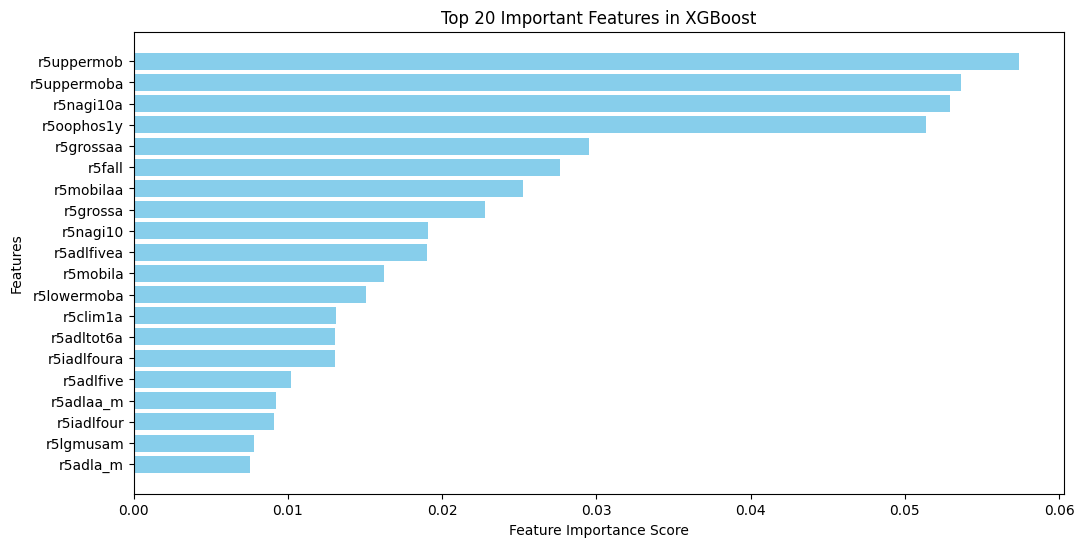

Feature Indices:
{'r5uppermob': 0, 'r5uppermoba': 1, 'r5nagi10a': 2, 'r5oophos1y': 3, 'r5grossaa': 4, 'r5fall': 5, 'r5mobilaa': 6, 'r5grossa': 7, 'r5nagi10': 8, 'r5adlfivea': 9, 'r5mobila': 10, 'r5lowermoba': 11, 'r5clim1a': 12, 'r5adltot6a': 13, 'r5iadlfoura': 14, 'r5adlfive': 15, 'r5adlaa_m': 16, 'r5iadlfour': 17, 'r5lgmusam': 18, 'r5adla_m': 19, 'r5dentst1y': 20, 'r5fallnum': 21, 'r5iwm': 22, 'r5cholst': 23, 'r5drink': 24}
Feature indices saved successfully.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix (Top 25 Features):
 [[1215  541]
 [  94  170]]

Classification Report (Top 25 Features):
               precision    recall  f1-score   support

           0     0.9282    0.6919    0.7928      1756
           1     0.2391    0.6439    0.3487       264

    accuracy                         0.6856      2020
   macro avg     0.5836    0.6679    0.5708      2020
weighted avg     0.8381    0.6856    0.7348      2020



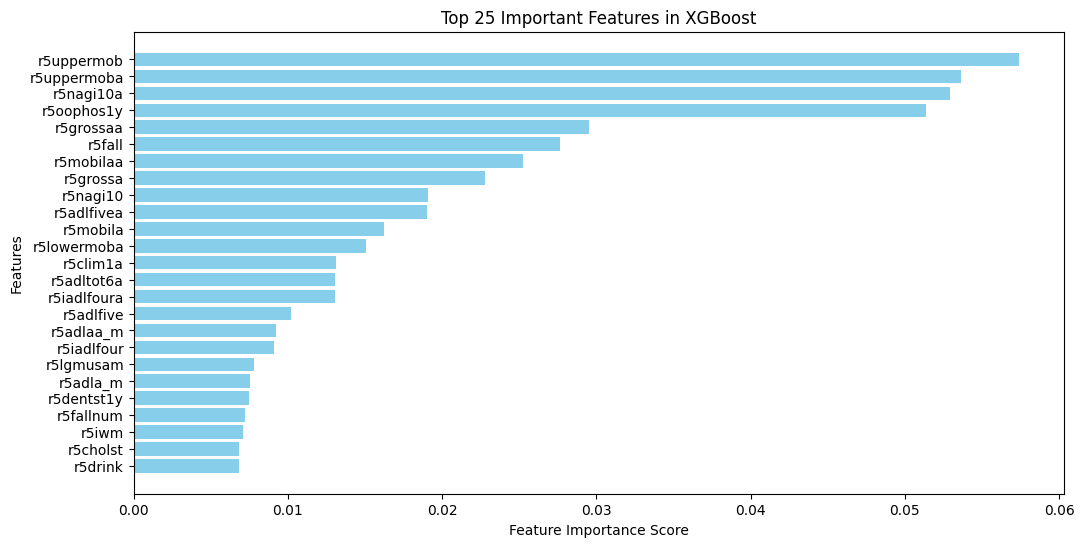

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = "cleaned_dataset.csv"  # Update this if needed
df = pd.read_csv(file_path)

# Drop non-numeric columns with too many unique values (e.g., IDs)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].nunique() > 30:  # Drop high-cardinality categorical features
        df.drop(columns=[col], inplace=True)

# Replace -1 with NaN
df.replace(-1, np.nan, inplace=True)

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna("Missing")  # Treat NaN as a separate category
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Store encoders for later use

# Drop rows with missing values (-1, -999)
df.replace(-999, np.nan, inplace=True)
df.dropna(inplace=True)

# Separate features (X) and target variable (y)
y = df['r5hosp1y']
X = df.drop(columns=['r5hosp1y'])  # Ensure we are dropping the target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define XGBoost model with class balancing
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    max_depth=6,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Get predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Get feature importance
feature_importance = xgb_clf.feature_importances_
features = X.columns

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Display the top 20 important features
print("\nTop 20 Most Important Features:\n")
print(feature_importance_df.head(20))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 20 Important Features in XGBoost")
plt.gca().invert_yaxis()
plt.show()

# Select the top 25 features
top_25_features = feature_importance_df.head(25)['Feature'].tolist()

# Create a new dataset with only the top 25 features
X_train_selected = X_train_resampled[top_25_features]
X_test_selected = X_test[top_25_features]

feature_indices = {feature: idx for idx, feature in enumerate(X_train_selected.columns)}
print("Feature Indices:")
print(feature_indices)

# with open("feature_indices.pkl", "wb") as file:
#     pickle.dump(feature_indices, file)

print("Feature indices saved successfully.")

# Train a new XGBoost model with the selected features
xgb_clf_selected = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1] * 1.5),
    max_depth=6,
    learning_rate=0.03,
    n_estimators=300,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=2,
    min_child_weight=1,
    random_state=42
)
xgb_clf_selected.fit(X_train_selected, y_train_resampled)

# Get predictions for the new model
y_pred_selected = xgb_clf_selected.predict(X_test_selected)

# Evaluate the new model
print("Confusion Matrix (Top 25 Features):\n", confusion_matrix(y_test, y_pred_selected))
print("\nClassification Report (Top 25 Features):\n", classification_report(y_test, y_pred_selected, digits=4))

# Plot feature importance for the new model
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:25], feature_importance_df['Importance'][:25], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 25 Important Features in XGBoost")
plt.gca().invert_yaxis()
plt.show()

# Saving Model

import pickle

# # Save model using Pickle
# with open("xgb_model.pkl", "wb") as file:
#     pickle.dump(xgb_clf_selected, file)

# print("Model saved successfully using Pickle.")


# import joblib

# # Save model using Joblib
# joblib.dump(xgb_clf_selected, "xgb_model.joblib")

# print("Model saved successfully using Joblib.")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:18:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[1645 1075]
 [ 172  270]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9053    0.6048    0.7251      2720
           1     0.2007    0.6109    0.3022       442

    accuracy                         0.6056      3162
   macro avg     0.5530    0.6078    0.5137      3162
weighted avg     0.8068    0.6056    0.6660      3162


Top 20 Most Important Features:

       Feature  Importance
8    r5fallnum    0.169760
6   r5uppermob    0.124883
4     r5grossa    0.117183
7   r5lowermob    0.098181
5   r5mobilsev    0.091505
1    r5adltot6    0.078899
3      r5nagi8    0.069954
2   r5iadlfour    0.067160
10    r5height    0.045628
0       r5adla    0.038761
12      r5agey    0.035911
11    r5weight    0.032079
9        r5bmi    0.030095


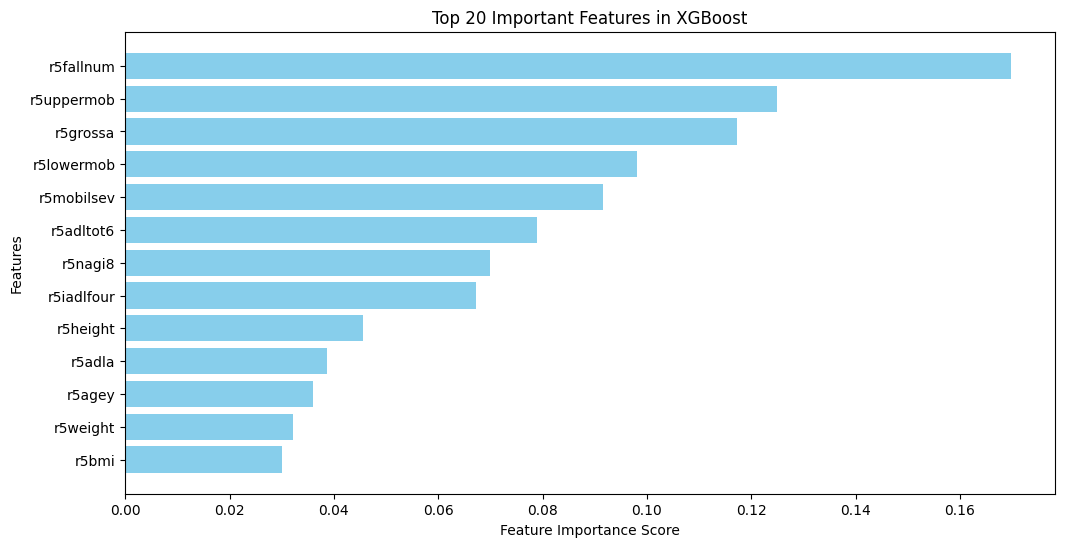

Feature Indices:
{'r5fallnum': 0, 'r5uppermob': 1, 'r5grossa': 2, 'r5lowermob': 3, 'r5mobilsev': 4, 'r5adltot6': 5, 'r5nagi8': 6, 'r5iadlfour': 7, 'r5height': 8, 'r5adla': 9, 'r5agey': 10, 'r5weight': 11, 'r5bmi': 12}
Feature indices saved successfully.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:18:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix (Top Features):
 [[ 986 1734]
 [  91  351]]

Classification Report (Top Features):
               precision    recall  f1-score   support

           0     0.9155    0.3625    0.5194      2720
           1     0.1683    0.7941    0.2778       442

    accuracy                         0.4228      3162
   macro avg     0.5419    0.5783    0.3986      3162
weighted avg     0.8111    0.4228    0.4856      3162



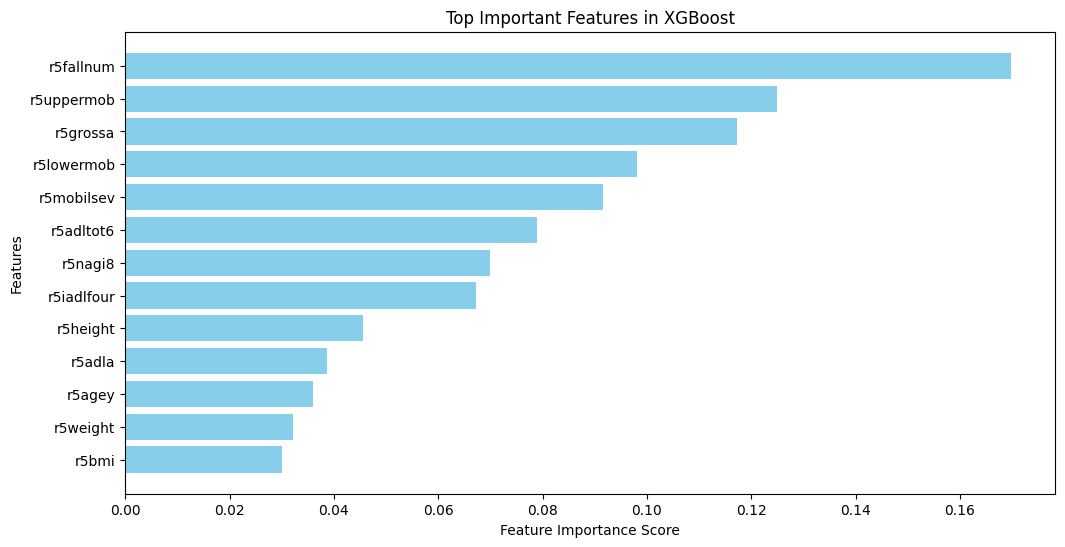

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = "cleaned_dataset.csv"  # Update this if needed
df = pd.read_csv(file_path)

# Drop non-numeric columns with too many unique values (e.g., IDs)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].nunique() > 30:  # Drop high-cardinality categorical features
        df.drop(columns=[col], inplace=True)

# Treat -1 and missing values as a separate category for categorical features
df.replace(-1, np.nan, inplace=True)  # Convert -1 to NaN first

label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna("Missing")  # Treat NaN as a separate category
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Store encoders for later use

# Treat missing values (-1, NaN) as a new category for numeric features
for col in df.select_dtypes(include=['number']).columns:
    df[col] = df[col].fillna(-9999)  # Assign a distinct value for missing data

# Separate features (X) and target variable (y)
y = df['r5hosp1y']
X = df[feature_names]
#X = df.drop(columns=['r5hosp1y'])


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define XGBoost model with class balancing
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    max_depth=6,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Get predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Get feature importance
feature_importance = xgb_clf.feature_importances_
features = X.columns

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Display the top 20 important features
print("\nTop 20 Most Important Features:\n")
print(feature_importance_df.head(20))

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 20 Important Features in XGBoost")
plt.gca().invert_yaxis()
plt.show()

# Select the top 25 features
top_25_features = feature_importance_df.head(25)['Feature'].tolist()

# Create a new dataset with only the top 25 features
X_train_selected = X_train_resampled[top_25_features]
X_test_selected = X_test[top_25_features]

feature_indices = {feature: idx for idx, feature in enumerate(X_train_selected.columns)}
print("Feature Indices:")
print(feature_indices)

# with open("feature_indices.pkl", "wb") as file:
#     pickle.dump(feature_indices, file)

print("Feature indices saved successfully.")

# Train a new XGBoost model with the selected features
xgb_clf_selected = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1] * 1.5),
    max_depth=6,
    learning_rate=0.03,
    n_estimators=300,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=2,
    min_child_weight=1,
    random_state=42
)
xgb_clf_selected.fit(X_train_selected, y_train_resampled)

# Get predictions for the new model
y_pred_selected = xgb_clf_selected.predict(X_test_selected)

# Evaluate the new model
print("Confusion Matrix (Top Features):\n", confusion_matrix(y_test, y_pred_selected))
print("\nClassification Report (Top Features):\n", classification_report(y_test, y_pred_selected, digits=4))

# Plot feature importance for the new model
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:25], feature_importance_df['Importance'][:25], color="skyblue")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top Important Features in XGBoost")
plt.gca().invert_yaxis()
plt.show()



#Saving Model

import pickle

# # Save model using Pickle
# with open("xgb_model.pkl", "wb") as file:
#     pickle.dump(xgb_clf_selected, file)

# print("Model saved successfully using Pickle.")


# import joblib

# # Save model using Joblib
# joblib.dump(xgb_clf_selected, "xgb_model.joblib")

# print("Model saved successfully using Joblib.")



In [ ]:
import pandas as pd

# Get probabilities for each class
y_pred_prob_selected = xgb_clf_selected.predict_proba(X_test_selected)

# Convert X_test_selected to DataFrame if it's not already
X_test_df = pd.DataFrame(X_test_selected, columns=X_train_selected.columns)

# Add actual and predicted labels to the DataFrame
X_test_df['Actual'] = y_test.values
X_test_df['Predicted'] = y_pred_selected

# Add probability of the predicted class
X_test_df['Probability_Class_0'] = y_pred_prob_selected[:, 0]  # Probability of class 0
X_test_df['Probability_Class_1'] = y_pred_prob_selected[:, 1]  # Probability of class 1


# Extract examples for each class based on actual labels
class_0_examples = X_test_df[X_test_df['Actual'] == 0]  # Class 0 examples
class_1_examples = X_test_df[X_test_df['Actual'] == 1]  # Class 1 examples

# Display some examples
print("Examples of Class 0 (Negative Class):\n", class_0_examples.head())
print("\nExamples of Class 1 (Positive Class):\n", class_1_examples.head())

# Save results to CSV for future analysis
X_test_df.to_csv("classified_examples_with_probabilities.csv", index=False)
print("\nPredictions with probabilities saved to 'classified_examples_with_probabilities.csv'.")


Examples of Class 0 (Negative Class):
        r5fallnum  r5uppermob  r5grossa  r5lowermob  r5mobilsev  r5adltot6  \
7834         5.0         1.0       1.0         3.0         4.0        1.0   
12562        0.0         0.0       0.0         0.0         0.0        0.0   
9739         2.0         0.0       0.0         1.0         1.0        0.0   
14035        0.0         0.0       0.0         0.0         0.0        0.0   
652         10.0         2.0       4.0         4.0         6.0        4.0   

       r5nagi8  r5iadlfour  r5height  r5adla  r5agey  r5weight        r5bmi  \
7834       4.0         0.0      1.54     1.0    63.0      74.0    31.202566   
12562      0.0         0.0      1.70     0.0    53.0      48.0    16.608995   
9739       1.0         0.0  -9999.00     0.0    53.0      89.0 -9999.000000   
14035      0.0         0.0      1.53     0.0    52.0      62.0    26.485540   
652        7.0         0.0      1.53     3.0    78.0      55.0    23.495237   

       Actual  Predicte

In [ ]:
false_positives = X_test_df[(X_test_df['Actual'] == 0) & (X_test_df['Predicted'] == 1)]
false_negatives = X_test_df[(X_test_df['Actual'] == 1) & (X_test_df['Predicted'] == 0)]

print("False Positives (Predicted 1 but Actual 0):\n", false_positives.head())
print("\nFalse Negatives (Predicted 0 but Actual 1):\n", false_negatives.head())


In [ ]:
class_0_examples.to_csv("class_0_examples.csv", index=False)
class_1_examples.to_csv("class_1_examples.csv", index=False)


In [ ]:
X_test_selected

,r5fallnum,r5uppermob,r5grossa,r5lowermob,r5mobilsev,r5adltot6,r5nagi8,r5iadlfour,r5height,r5adla,r5agey,r5weight,r5bmi
7834,5.0,1.0,1.0,3.0,4.0,1.0,4.0,0.0,1.54,1.0,63.0,74.0,31.202566
12562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.70,0.0,53.0,48.0,16.608995
9739,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,-9999.00,0.0,53.0,89.0,-9999.000000
14035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.53,0.0,52.0,62.0,26.485540
652,10.0,2.0,4.0,4.0,6.0,4.0,7.0,0.0,1.53,3.0,78.0,55.0,23.495237
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766,2.0,2.0,0.0,2.0,4.0,0.0,3.0,1.0,1.65,0.0,84.0,70.0,25.711662
5749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9999.00,0.0,68.0,80.0,-9999.000000
13281,0.0,1.0,0.0,3.0,4.0,1.0,5.0,0.0,1.65,0.0,50.0,60.0,22.038568
9033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.60,0.0,58.0,65.0,25.390625


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer



# Define the LightGBM model
lgb_model = lgb.LGBMClassifier(
    objective='binary',            # Binary classification objective
    metric='binary_logloss',       # Logarithmic loss metric
    is_unbalance=True,             # Handle class imbalance automatically
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # Manually adjust for class imbalance
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3],       # Maximum depth of the tree
    'learning_rate': [0.01, 0.1, 0.001, 0.2],  # Learning rate
    'n_estimators': [50, 100, 200],  # Number of boosting rounds (trees)
    'subsample': [0.2, 0.5, 0.8],  # Fraction of samples used for each tree
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used for each tree
    'scale_pos_weight': [1, (len(y_train) - sum(y_train)) / sum(y_train)]
}

# Setup GridSearchCV to optimize for recall
grid_search = GridSearchCV(
    estimator=lgb_model,           # LightGBM model
    param_grid=param_grid,         # Hyperparameter grid to search
    scoring=make_scorer(recall_score),  # Use recall as the evaluation metric
    cv=5,                          # 5-fold cross-validation
    verbose=2,                     # Print detailed output
    n_jobs=-1                      # Use all available CPUs for parallel processing
)

# Train the model using GridSearchCV
# Select the top 25 features
top_25_features = feature_importance_df.head(25)['Feature'].tolist()

# Create a new dataset with only the top 25 features
# X_train_selected = X_train_resampled[top_25_features]
# X_test_selected = X_test[top_25_features]

grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Recall: {grid_search.best_score_:.4f}")

# Use the best model found by GridSearchCV to make predictions on the test set
best_lgb_model = grid_search.best_estimator_

y_pred = best_lgb_model.predict(X_test)

# Evaluate the final model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py", line 1284, in fit
    super().fit(
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/sklearn.py", line 955, in fit
    self._Booster = train(
                    ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py"

[LightGBM] [Info] Number of positive: 3511, number of negative: 7022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16671
[LightGBM] [Info] Number of data points in the train set: 10533, number of used features: 258
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = "final_cleaned_dataset_crammer.csv"  # Update this if needed
df = pd.read_csv(file_path)

# Drop non-numeric columns with too many unique values (e.g., IDs)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].nunique() > 30:  # Drop high-cardinality categorical features
        df.drop(columns=[col], inplace=True)

# Treat -1 and missing values as a separate category for categorical features
df.replace(-1, np.nan, inplace=True)  # Convert -1 to NaN first

label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna("Missing")  # Treat NaN as a separate category
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Store encoders for later use

# Treat missing values (-1, NaN) as a new category for numeric features
for col in df.select_dtypes(include=['number']).columns:
    df[col] = df[col].fillna(-9999)  # Assign a distinct value for missing data

# Separate features (X) and target variable (y)
y = df['r5hosp1y']
X = df.drop(columns=['r5hosp1y'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define XGBoost model with class balancing
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),  # Auto-balance classes
    max_depth=6,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Get predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[2330  390]
 [ 198  244]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9217    0.8566    0.8880      2720
           1     0.3849    0.5520    0.4535       442

    accuracy                         0.8140      3162
   macro avg     0.6533    0.7043    0.6707      3162
weighted avg     0.8466    0.8140    0.8272      3162

